In [1]:
# Statistically significant cutoff.
alpha = 0.05
m = 2*6*5 + 2*13
alpha = alpha * (1-(1 - alpha)**(m))

In [2]:
alpha

0.04939298411094704

In [3]:
import pickle as pkl
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys
sys.path.insert(1, '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/')
import metrics
import signatures
import corrstats #https://github.com/psinger/CorrelationStats/blob/master/corrstats.py

import scipy
import scipy.stats as st
import statsmodels as sm

# For the regression.
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import xarray as xr
proj_dir = '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/'
data_dir = proj_dir + 'data/'
nldas_dir = data_dir + 'basin_dataset_public_v1p2/basin_mean_forcing/nldas_extended/'

In [4]:
dynamic_plots = False
# this command is executed twice for interactive plotting in Jupyter notebook
if dynamic_plots:
    %matplotlib notebook
    %matplotlib notebook

In [5]:
# Get all the metrics available in one list.
mets = metrics.get_available_metrics()
nmets = len(mets)

In [6]:
# LSTM
LSTM_A = ['run_1103_121106_seed83357', 'run_1103_113114_seed604500', 
      'run_1103_121501_seed484165', 'run_1203_181142_seed398144',
      'run_1203_181142_seed602441', 'run_1203_181142_seed712381',
      'run_2402_183736_seed785305', 'run_1906_161642_seed785306',
      'run_1806_082707_seed785307', 'run_1806_054617_seed785308']
# LSTM (with only atm as dynamic inputs) trained only on the calibrated basins.
LSTM_Ac = ['run_0607_174951_seed83357', 'run_0807_144624_seed398144',
       'run_0607_175422_seed785306', 
       'run_0607_234356_seed785307', 'run_0707_130905_seed785308']

#final with RT values
LSTM_ASF = ['run_0806_123405_seed83357', 'run_0806_233426_seed604500',
      'run_0906_004032_seed398144', 'run_0906_235116_seed484165',
      'run_1206_102325_seed712381', 'run_1206_173942_seed602441',
      'run_1506_111315_seed785305', 'run_1506_221658_seed785306',
      'run_1606_045259_seed785307', 'run_1606_155403_seed785308']
# Version 2 without the Atmospheric forcing conditions
# Trained on NWM states and fluxes as dynamic inputs only
LSTM_SF = ['run_2306_104142_seed83357','run_2306_222450_seed398144', 
       'run_2406_055649_seed484165','run_0601_125106_seed604500', 
       'run_0601_184922_seed712381','run_0601_185430_seed602441',
       'run_0701_012022_seed785305','run_0701_012102_seed785306',
       'run_0701_012321_seed785307','run_0701_012257_seed785308']
# Version 2 without the Atmospheric forcing conditions
# Trained on NWM states as dynamic inputs only
LSTM_S = ['run_2806_154330_seed83357', 'run_1507_151710_seed398144', 
        'run_1507_215037_seed484165', 'run_1607_113607_seed604500',
        'run_0601_120756_seed712381', 'run_0701_012915_seed602441',
        'run_0701_013038_seed785305', 'run_0701_013059_seed785306',
        'run_0701_013152_seed785307', 'run_0701_013307_seed785308']
# Version 2 trained only on the calibrated basins. But then evaluated on all basins.
LSTM_ASFc = ['run_0207_030107_seed83357', 'run_0107_175548_seed604500',
       'run_0207_002935_seed398144', 'run_0107_175548_seed484165',
       'run_0207_103653_seed712381', 'run_0207_005343_seed602441',
       'run_0207_110648_seed785305', 'run_0207_110648_seed785306',
       'run_0207_181413_seed785307', 'run_0207_181413_seed785307']

In [24]:
#######################################################################################
###########  INITIALIZE A BUNCH OF STUFF   #######   INITIALIZE A BUNCH OF STUFF  #####
#######################################################################################

#####################################
calculate_metric_dictionary = False ##
calculate_flow_categories = False  ##
calculate_metric_matrix = False     ##
#####################################


# Definitions
area_index='area_geospa_fabric'
sample_basin = '11532500'
drop_these = ['high_prec_timing','root_depth_50',
              'root_depth_99','zero_q_freq','water_frac','organic_frac']

val_start='1994-10-01'
val_end='2003-09-30'
date_range = pd.date_range(start=val_start, end=val_end)
# train_start='2004-10-01'
# train_end='2014-09-30'
# training_date_range = pd.date_range(start=train_start, end=train_end)

sample_lstm_run = 'runs/run_1103_121106_seed83357/lstm_seed83357_statclimtest.p'


# A list of all the run types. LSTM version numbers explained in comments above
base_models=['NWM', 'LSTM_A']

lstm_version_list = ['LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_SF', 'LSTM_S', 'LSTM_ASFc']
nwm_lstm_version_list = ['NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_SF', 'LSTM_S', 'LSTM_ASFc']
obs_nwm_lstm_version_list = ['obs','NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_SF', 'LSTM_S', 'LSTM_ASFc']

count_zero_q_freq = {m:0 for m in obs_nwm_lstm_version_list}
dict_ensembles = {'LSTM_A':LSTM_A, 'LSTM_Ac':LSTM_Ac, 'LSTM_ASF':LSTM_ASF, 
                  'LSTM_SF':LSTM_SF, 'LSTM_S':LSTM_S, 'LSTM_ASFc':LSTM_ASFc}

n_models = len(nwm_lstm_version_list)

combined_metric_list = ['nse', 'bias', 'variance', 'pearsonr']

use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total Bias', 'Peak Timing Error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total (absolute) Bias', 'Peak Timing Error']
use_metric_locs = [0,6,11]


flow_categories = ['all', 'rise', 'fall','above_mean', 'below_mean',
                       'above_mid', 'below_mid', 'below_20', 'above_80']
flow_categories_slim = ['all', 'rise' , 'fall','below_20', 'above_80']

flow_categories_very_slim = ['all', 'rise' , 'fall']

# Read in basin list
basin_list = []
with open(proj_dir+'data/basin_list.txt', 'r') as f:
    for line in f:
        basin_list.append(str(line[0:8]))
nbasins = len(basin_list)

In [8]:
if True: # Open the attributes from the coding workshop. These are already set up to do regression
    openthis = '/home/NearingLab/data/camels_all_coding_workshop.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = '/home/NearingLab/data/camels_attributes_v2.0/camels_all.txt'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)

In [9]:
openthis = '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/data/calibrated_basins.txt'
calibrated_basins = pd.read_csv(openthis)
cb = calibrated_basins['Domain_Meta.gage_id'].values
attributes['calibrated'] = [np.nan]*attributes.shape[0]
calibrated_basins_list = []
for ib, b in enumerate(basin_list):
    if b in cb:
        calibrated_basins_list.append(b)
        attributes.loc[int(b), 'calibrated'] = True
    else:
        attributes.loc[int(b), 'calibrated'] = False

In [10]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [11]:
# Convert NWM streamflow (m3/s) to mm
sid = 60*60*24 # seconds in day
mikm = 0.001 # meter in kilometer
mmim = 0.001 # millimeter in meter

In [12]:
# open a sample of a LSTM run, to get the observation values
openthis = proj_dir+sample_lstm_run
with open(openthis, 'rb') as f:
    lstm_sample = pkl.load(f)

In [13]:
# NWM Reanalysis
openthis = proj_dir+'data/nwm_chrt_v2_1d_local.p'
with open(openthis, 'rb') as f:
    nwm = pkl.load(f)

In [14]:
# Empty metrics array, to fill in a dictionary with the different run version, and basins.
empty_metrics_array = np.full([nbasins,nmets],np.nan)

# An empty dictionary of basins, to then put in a dictionary of flow types
empty_basins_q_dictionary = {b:np.full(nwm[b]['streamflow'].shape, np.nan) for b in basin_list}

# This will have the ensemble mean flow for each simulation type
ensemble_q_dictionary = {rt:empty_basins_q_dictionary for rt in nwm_lstm_version_list}

In [15]:
# Convert the NWM streamflow (m3/s) to surface runoff (mm)
for i, b in enumerate(basin_list):
    A = attributes.loc[int(b), area_index]
    conversion_factor = sid * mmim / A
    ensemble_q_dictionary['NWM'][b] = conversion_factor * nwm[b]['streamflow']

In [16]:
# Get the streamflow predictions for a specific run instance
def get_streamflow_prediction(specifc_run):
    # Get the seed from the run name
    seed = specifc_run.split('seed')[1]
    
    flow_dict = {b:empty_basins_q_dictionary for b in basin_list}
    seed = str(seed)
    openthis = proj_dir+'runs/'+specifc_run+'/lstm_seed'+seed+'_statclimtest.p'
    with open(openthis, 'rb') as f:
        temp_simulation_file = pkl.load(f)
    
    for i, b in enumerate(basin_list):
        flow_dict[b] = temp_simulation_file[b].loc[date_range, 'qsim']

    return flow_dict

In [17]:
# Combined all the ensemble flows into ONE mean ensemble flow.
# loop through the simulation types
seed_discrepancies = {version:[] for version in lstm_version_list}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    for em in range(n_ensemble_members):
        temp_streamflow_sum=0 # For average flows across basins.
        # If it is the first, set the mean values to the streamflow
        if em == 0:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            mean_streamflow = temp_streamflow
        # If it is not the first, the sum the streamflow values, will devide by n below
        else:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            # Loop through the basins, to sum the streamflow values up seperately
            for ib, b in enumerate(basin_list):
                mean_streamflow[b] = mean_streamflow[b] + temp_streamflow[b]
                
        # Record the mean streamflow across basins for each ensemble member, to get seed discrepancies.
        for ib, b in enumerate(basin_list):
            temp_streamflow_sum = temp_streamflow_sum + np.mean(temp_streamflow[b])
        seed_discrepancies[sim_type].append(temp_streamflow_sum/nbasins)
        
    # Devide by the number of ensemble members at each basin to get the average flow.
    for ib, b in enumerate(basin_list):
        mean_streamflow[b] = mean_streamflow[b] / n_ensemble_members
    # Finally put the average flow in the ensemble flow dictionary under the corresponding simulation type.
    ensemble_q_dictionary[sim_type] = mean_streamflow
    
    seed_mean = np.mean(seed_discrepancies[sim_type])
    seed_std = np.std(seed_discrepancies[sim_type])
    print('relative standard error of the mean streamflow = {:.2f}'.format(seed_std/seed_mean))

LSTM_A
relative standard error of the mean streamflow = 0.01
LSTM_Ac
relative standard error of the mean streamflow = 0.01
LSTM_ASF
relative standard error of the mean streamflow = 0.01
LSTM_SF
relative standard error of the mean streamflow = 0.01
LSTM_S
relative standard error of the mean streamflow = 0.01
LSTM_ASFc
relative standard error of the mean streamflow = 0.01


In [18]:
# Caclulate the difference in NSE across ensemble members.
seed_discrepancies = {version:[] for version in lstm_version_list}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    list_sim=[]
    list_obs=[]
    for em in range(n_ensemble_members):
        dict_sim = get_streamflow_prediction(dict_ensembles[sim_type][em])
        for i, b in enumerate(basin_list):
            list_sim.extend(dict_sim[b].loc[date_range])
            list_obs.extend(lstm_sample[b].loc[date_range, 'qobs'])
        xsim = xr.DataArray(list_sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(list_obs).rename({'dim_0': 'date'})
        seed_discrepancies[sim_type].append(metrics.nse(xobs, xsim))
    print('Percent NSE discrepancy between random seeds = {:.4f}'.format(\
           100*np.std(seed_discrepancies[sim_type])/np.mean(seed_discrepancies[sim_type])))

LSTM_A
Percent NSE discrepancy between random seeds = 0.0806
LSTM_Ac
Percent NSE discrepancy between random seeds = 0.1107
LSTM_ASF
Percent NSE discrepancy between random seeds = 0.0570
LSTM_SF
Percent NSE discrepancy between random seeds = 0.0749
LSTM_S
Percent NSE discrepancy between random seeds = 0.1463
LSTM_ASFc
Percent NSE discrepancy between random seeds = 0.1839


# calculate all the evaluation metrics for each basin.

In [29]:
# calculate all the evaluation metrics for each basin.
# This function works if proj_dir and empty_mets have been defined above. 
def calculate_metric(dict_sim, date_range):
    met_dict = np.copy(empty_metrics_array)
    for i, b in enumerate(basin_list):
        obs = lstm_sample[b].loc[date_range, 'qobs']
        sim = dict_sim[b].loc[date_range]
        xsim = xr.DataArray(sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(obs).rename({'dim_0': 'date'})
        metric_values = metrics.calculate_metrics(xobs,xsim, mets)
        #Have to loop through the dictionary to get the specific metric value.
        for imet, kmet in enumerate(mets):
            met_dict[i][imet] = metric_values[kmet]
    
    return met_dict

In [20]:
if calculate_metric_dictionary:
    # This will have the metrics for each flow type, calculated across all basins.
    ensemble_metric_dictionary = {rt:empty_metrics_array for rt in nwm_lstm_version_list}
    # Calculate all the metrics for each simulation type.
    for simulation in nwm_lstm_version_list:
        ensemble_metric_dictionary[simulation] = calculate_metric(ensemble_q_dictionary[simulation], date_range)
    with open(data_dir+'performance_metrics_2021_revision.p','wb') as f:
        pkl.dump(ensemble_metric_dictionary, f, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(data_dir+'performance_metrics_2021_revision.p','rb') as f:
        ensemble_metric_dictionary = pkl.load(f)

In [27]:
def CALCULATE_CORRELATION(control, test, use_metrics=use_metrics):
    corrs = np.full(len(use_metrics), np.nan)
    for m, metric in enumerate(use_metrics):
        test_m = np.array(ensemble_metric_dictionary[test][:,metric])
        control_m = np.array(ensemble_metric_dictionary[control][:,metric])
        corrs[m] = st.stats.pearsonr(control_m, test_m)[0]
    return corrs

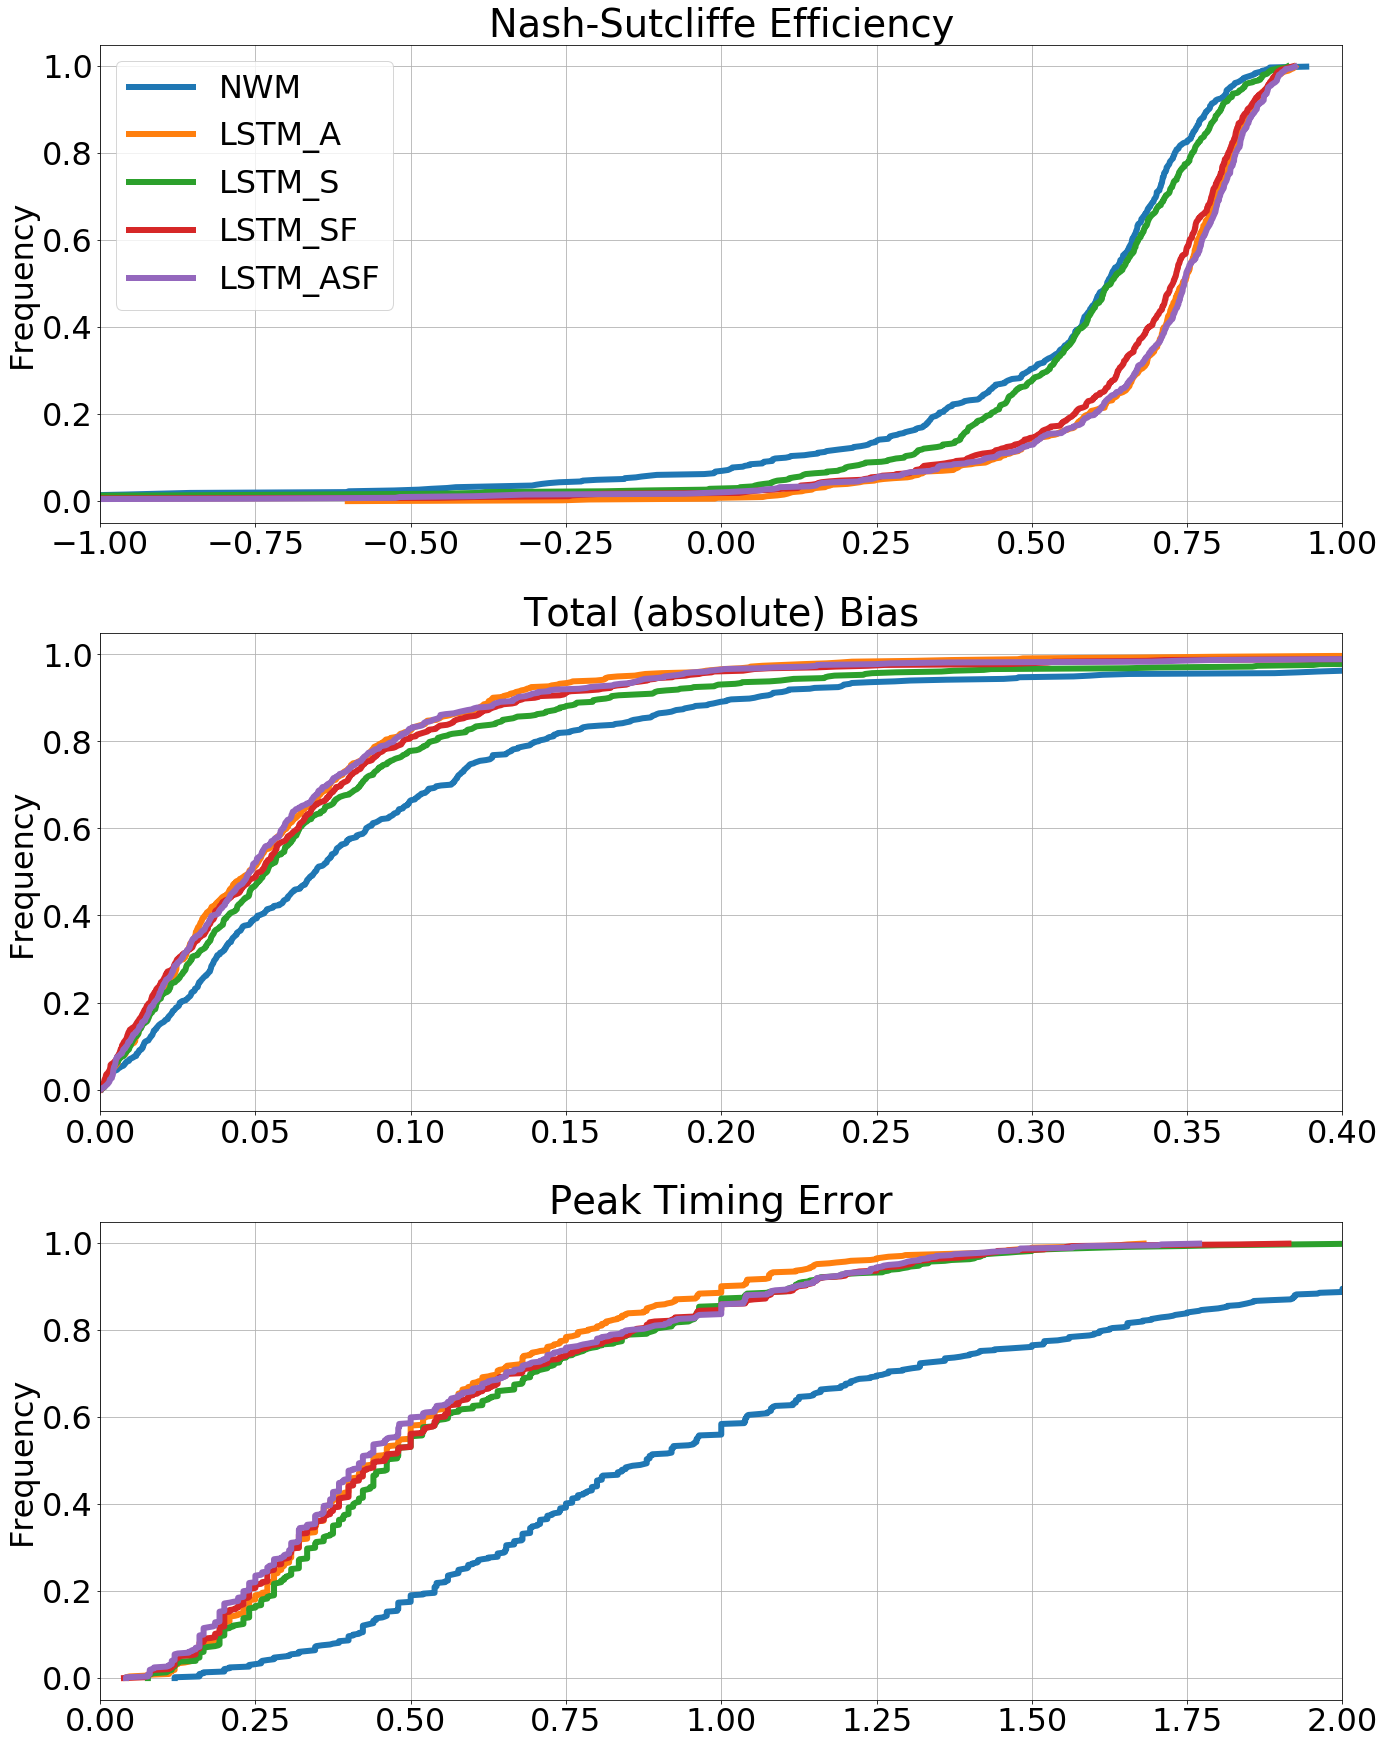

In [31]:
met_lims = [[-1,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams.update({'font.size': 32})
fig, axes = plt.subplots(3, figsize=(20,25))

plot_mods = ['NWM','LSTM_A','LSTM_S', 'LSTM_SF', 'LSTM_ASF']
for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary[i_plot_mods][:,nmet]) for i_plot_mods in plot_mods]
    # Just use absolute values for the bias, since negative values are hard to interpret
    if nmet==6:
        x = list(np.abs(x))
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], label=plot_mods[imod], lw=6)
        axes[imet].grid()
        axes[imet].set_xlim(list(met_lims[nmet]))
        axes[imet].set_title(use_metric_names[imet])
        axes[imet].set_ylabel('Frequency')


        
axes[0].legend(fontsize=32)
fig.tight_layout() 

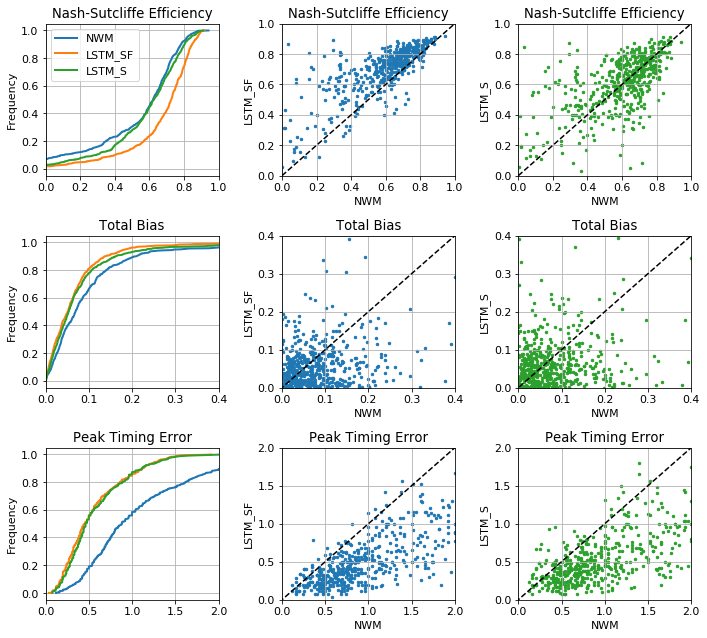

In [31]:
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(3,3, figsize=(10,9))

plot_mods = ['NWM', 'LSTM_SF', 'LSTM_S']
for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary[i_plot_mods][:,nmet]) for i_plot_mods in plot_mods]
    if nmet==6:
        x = list(np.abs(x))
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes[imet,0].plot(plotdata,  yvalues[:len(plotdata)], label=plot_mods[imod], lw=2)
        axes[imet,0].grid()
        axes[imet,0].set_xlim(list(met_lims[nmet]))
        axes[imet,0].set_title(metric_names[imet])
        axes[imet,0].set_ylabel('Frequency')

    ydata = x[1]
    xdata = x[0]
    axes[imet,1].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,1].scatter(xdata,  ydata, label=plot_mods[imod], marker='o', s=6, c=cycle[0])
    axes[imet,1].grid()
    axes[imet,1].set_xlim(list(met_lims[nmet]))
    axes[imet,1].set_ylim(list(met_lims[nmet]))
#     mmiinn = np.min(np.minimum(xdata, ydata))
#     mmaaxx = np.max(np.maximum(xdata, ydata))
#     axes[imet,1].set_xlim([mmiinn, mmaaxx])
#     axes[imet,1].set_ylim([mmiinn, mmaaxx])
    axes[imet,1].set_title(metric_names[imet])
    axes[imet,1].set_ylabel('LSTM_SF')
    axes[imet,1].set_xlabel('NWM')
    corr = 'r$^2$: {:.2f}'.format(st.stats.pearsonr(xdata, ydata)[0])
#    axes[imet,1].text(place_text[imet][0][0],place_text[imet][0][1],corr)

    ydata = x[2]
    xdata = x[0]
    axes[imet,2].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,2].scatter(xdata,  ydata, label=plot_mods[imod], marker='o', s=6, c=cycle[2])
    axes[imet,2].grid()
    axes[imet,2].set_xlim(list(met_lims[nmet]))
    axes[imet,2].set_ylim(list(met_lims[nmet]))
#     mmiinn = np.min(np.minimum(xdata, ydata))
#     mmaaxx = np.max(np.maximum(xdata, ydata))
#     axes[imet,2].set_xlim([mmiinn, mmaaxx])
#     axes[imet,2].set_ylim([mmiinn, mmaaxx])
    axes[imet,2].set_title(metric_names[imet])
    axes[imet,2].set_ylabel('LSTM_S')
    axes[imet,2].set_xlabel('NWM')
    corr = 'r$^2$: {:.2f}'.format(st.stats.pearsonr(xdata, ydata)[0])
#    axes[imet,2].text(place_text[imet][1][0],place_text[imet][1][1],corr)
        
axes[0,0].legend()
fig.tight_layout() 

# Plot the change in performance on a map

In [32]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [33]:
# spatial plot of improvements
bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
display_colors_from_control = {'NWM':'PRGn', 'LSTM_A':'PRGn'} #Alternative color scheme: 'PuOr'
display_bounds_from_control = {'NWM':[(-0,1), (-0.2,0.1), (0,2)], 'LSTM_A':[(-0,1), (-0.2,0.1), (0,2)]}

In [34]:
def PERFORMANCE_IMPROVEMENTS(control, test, percent=False):
    improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    percent_improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    for m, metric in enumerate(use_metrics):
        imet=use_metric_locs[m]
        if optimal[m] == 1:
            improvement[:,m] = ensemble_metric_dictionary[test][:,imet] - \
                               ensemble_metric_dictionary[control][:,imet]
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metric_dictionary[control][:,imet])
        elif optimal[m] == 0:
            improvement[:,m] = np.abs(ensemble_metric_dictionary[control][:,imet]) - \
                                np.abs(ensemble_metric_dictionary[test][:,imet])
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metric_dictionary[control][:,imet])
    if percent:
        return percent_improvement
    else:
        return improvement

In [35]:
# Correlation grid
for imet, nmet in enumerate(use_metric_locs):
    print(use_metrics[imet])
    corrs = pd.DataFrame(index=nwm_lstm_version_list, columns=nwm_lstm_version_list)
    for i, imod in enumerate(nwm_lstm_version_list):
        for j, jmod in enumerate(nwm_lstm_version_list):
            corrs.iloc[i,j] = CALCULATE_CORRELATION(imod, jmod, use_metrics=[nmet])[0]
    print(corrs)

NSE
                NWM    LSTM_A   LSTM_Ac  LSTM_ASF   LSTM_SF    LSTM_S  \
NWM               1  0.406531  0.669919  0.710596   0.70057  0.360566   
LSTM_A     0.406531         1  0.750612  0.782916  0.763352  0.497187   
LSTM_Ac    0.669919  0.750612         1    0.6698  0.656005  0.452886   
LSTM_ASF   0.710596  0.782916    0.6698         1  0.982861   0.65153   
LSTM_SF     0.70057  0.763352  0.656005  0.982861         1  0.717287   
LSTM_S     0.360566  0.497187  0.452886   0.65153  0.717287         1   
LSTM_ASFc  0.637254  0.269676  0.731886  0.310574   0.30144  0.194429   

          LSTM_ASFc  
NWM        0.637254  
LSTM_A     0.269676  
LSTM_Ac    0.731886  
LSTM_ASF   0.310574  
LSTM_SF     0.30144  
LSTM_S     0.194429  
LSTM_ASFc         1  
Beta-NSE
                NWM    LSTM_A   LSTM_Ac  LSTM_ASF   LSTM_SF    LSTM_S  \
NWM               1  0.308931  0.403494   0.63722  0.629663  0.475228   
LSTM_A     0.308931         1  0.783946  0.689246  0.671984   0.68325   
LSTM_Ac

In [36]:
use_metrics

['NSE', 'Beta-NSE', 'Peak-Timing']

In [37]:
def COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, threshold=1, verbose=True):
    for m, metric in enumerate(use_metrics):
        count_improved = 0
        count_detriment = 0
        count_total = 0
        imet=use_metric_locs[m]
        for i, ival in enumerate(improvement[:,m]):
            if ensemble_metric_dictionary['NWM'][i,0] < threshold:
                count_total += 1
                if ival > 0:
                    count_improved+= 1
                if ival < 0:
                    count_detriment+= 1
        if verbose:
            print(metric)
            print('Number of improved basins = {}, {:.2f}%'.format(count_improved, 
                                                                   count_improved/count_total))
            print('Number of detrimented basins = {}, {:.2f}%'.format(count_detriment, 
                                                                      count_detriment/count_total))
        else:
            if metric == 'NSE':
                return count_improved/count_total

In [30]:
def PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, percent=False):
    
    bound = display_bounds_from_control[control]
    
    fig = plt.figure(figsize=(10, 9))
    gs = fig.add_gridspec(len(use_metrics),3)

    for m, metric in enumerate(use_metrics):

        imet=use_metric_locs[m]

        ax0 = fig.add_subplot(gs[m,:2])
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[:,m],
                        s=20,
                        cmap=display_colors_from_control[control],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
        ax0.set_title(use_metric_names[m])
        if m == 2:
            ax0.set_xlabel('Longitude')
        if m == 1:
            ax0.set_ylabel('Latitude')
        clims = im.get_clim()

        # colorbar
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax1 = fig.add_subplot(gs[m,2])    
        ax1.plot(bounds[m], bounds[m], 'k--', lw=0.6)
        for b, basin in enumerate(basin_list):
            basin_color = im.to_rgba(improvement[b,m])
            ax1.scatter(ensemble_metric_dictionary[control][b,imet], 
                        ensemble_metric_dictionary[test][b,imet],
                        s=5,
                        color=im.to_rgba(improvement[b,m]))
        ax1.set_xlabel(control)
        ax1.set_ylabel(test)
        ax1.set_xlim(bounds[m])
        ax1.set_ylim(bounds[m])
        ax1.grid()

    plt.tight_layout()

NSE
Number of improved basins = 462, 0.87%
Number of detrimented basins = 69, 0.13%
Beta-NSE
Number of improved basins = 325, 0.61%
Number of detrimented basins = 206, 0.39%
Peak-Timing
Number of improved basins = 487, 0.92%
Number of detrimented basins = 28, 0.05%


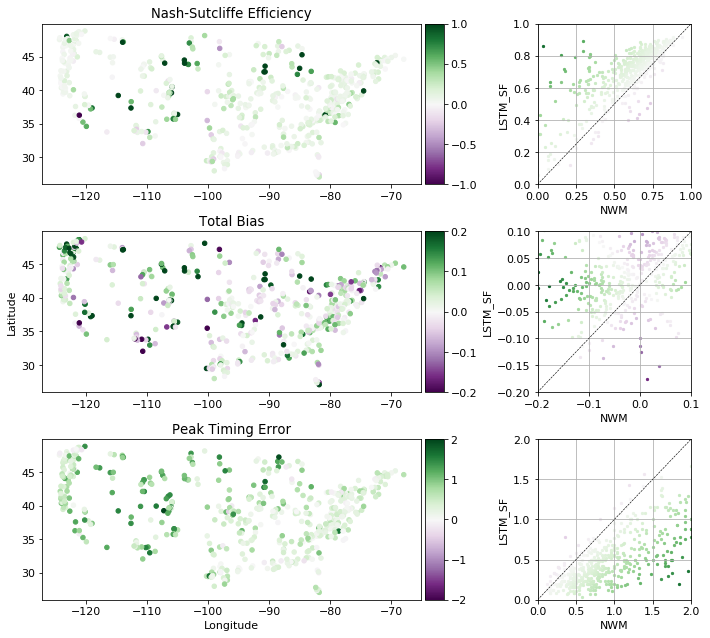

In [39]:
control='NWM'
test='LSTM_SF'
improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)

NSE
Number of improved basins = 300, 0.56%
Number of detrimented basins = 231, 0.44%
Beta-NSE
Number of improved basins = 308, 0.58%
Number of detrimented basins = 223, 0.42%
Peak-Timing
Number of improved basins = 464, 0.87%
Number of detrimented basins = 50, 0.09%


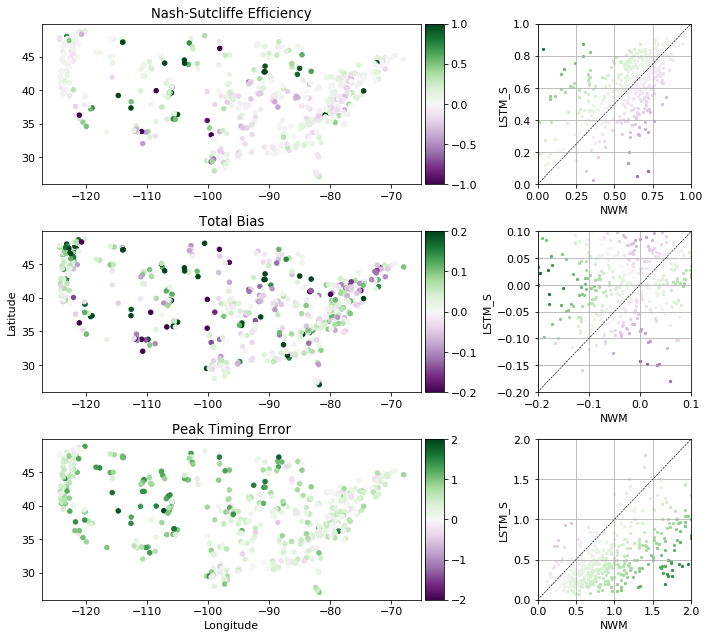

In [40]:
control='NWM'
test='LSTM_S'
improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)

NSE
Number of improved basins = 291, 0.55%
Number of detrimented basins = 240, 0.45%
Beta-NSE
Number of improved basins = 258, 0.49%
Number of detrimented basins = 273, 0.51%
Peak-Timing
Number of improved basins = 228, 0.43%
Number of detrimented basins = 223, 0.42%


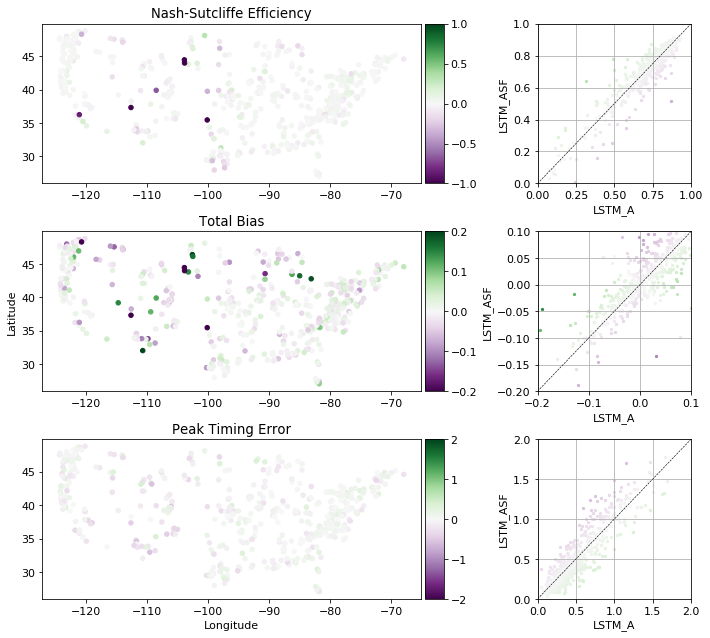

In [41]:
control='LSTM_A'
test='LSTM_ASF'
improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)

# Performance metrics for the NWM and the LSTM, LSTM Post Processor

In [42]:
# Get the days of the record that correspond to each flow type, for each basin.

if calculate_flow_categories:
    flow_dates = {fc:{b:[] for b in basin_list} for fc in flow_categories}

    for ib, b in enumerate(basin_list):  
        df = lstm_sample[b]

        for i_date, today in enumerate(date_range):
            # For a baseline also evaluate the whole record
            flow_dates['all'][b].append(today)

            # Rising and falling limbs
            if i_date>0:
                yesterday =  date_range[i_date-1]
                diff_1d = df.loc[today,'qobs']-df.loc[yesterday,'qobs']
                if diff_1d < 0:
                    flow_dates['fall'][b].append(today)
                if diff_1d > 0:
                    flow_dates['rise'][b].append(today)

            # Above or below Median
            if df.loc[today,'qobs'] > np.median(df.loc[:,'qobs']):
                flow_dates['above_mid'][b].append(today)
            else:
                flow_dates['below_mid'][b].append(today)

            # Above or below Mean
            if df.loc[today,'qobs'] > np.mean(df.loc[:,'qobs']):
                flow_dates['above_mean'][b].append(today)
            else:
                flow_dates['below_mean'][b].append(today)

            # Above or below 20th/80th percentile
            if df.loc[today,'qobs'] > np.percentile(df.loc[:,'qobs'], 80):
                flow_dates['above_80'][b].append(today)
            elif df.loc[today,'qobs'] < np.percentile(df.loc[:,'qobs'], 20):
                flow_dates['below_20'][b].append(today) 
        # Save values to pickle file
        with open(data_dir+'flow_category_dates.p','wb') as f:
            pkl.dump(flow_dates, f)
else:
    with open(data_dir+'flow_category_dates.p','rb') as f:
        flow_dates = pkl.load(f)

In [43]:
def calc_nse(obs, sim):
    diff1 = obs - sim
    diff2 = obs - np.mean(obs)
    numer = np.nanmean(np.power(diff1,2))
    denom = np.nanmean(np.power(diff2,2))
    return 1-numer/denom
def calc_bias(obs, sim):
    sum_obs = np.sum(obs)
    sum_sim = np.sum(sim)
    return sum_obs - sum_sim
def calc_beta_nse(obs, sim):
    return float((sim.mean() - obs.mean()) / obs.std())
def calc_alpha_nse(obs, sim):
    return float(sim.std() / obs.std())

In [44]:
# Get all the metrics available in one list.

if calculate_metric_matrix:

    met_mat = {fc:np.full([nbasins,n_models,nmets],np.nan) for fc in flow_categories}

    flow_mat = {fc:{mt:[] for mt in obs_nwm_lstm_version_list} for fc in flow_categories}

    did_not_calculate = []

    # Loop through the basins and calculate the performance metric.
    for ib, b in enumerate(basin_list):  
        # Keep a record of any infinities that come out of performance metric calculations.
        basin_inf = {fc:[] for fc in nwm_lstm_version_list}

        # Loop through the flow categories, and calculate the performance metrics.
        # Any flow category that is split up by percentile 
        for fc in flow_categories:
            # But some of the metrics do not make sense when the flow is split up by category
            #             i.e., the timing metrics don't make sense without consecutive days.
            if fc != flow_categories[0]:
                loop_mets = mets[0:7]
            else:
                loop_mets = mets

            flow_set = flow_dates[fc][b]

            xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
            flow_mat[fc]['obs'].extend(list(lstm_sample[b].loc[flow_set,'qobs']))

            # Do not calculate the metrics on the basins that have a mean close to zero.
            # This will lead to -inf or very low (-100xxx) Nash-Sutcliffe values.
            if np.mean(lstm_sample[b].loc[flow_set, 'qobs']) > 0:
                is_calc_metrics = True
            else:
                is_calc_metrics = False
                did_not_calculate.append([b,fc])

            # 1) combined flows from all basins into one dictionary, for overall metrics
            # 2) Calculate the metrics for each model type.
            for imt, model_type in enumerate(nwm_lstm_version_list):
                # Combine all the basins so the metrics can be calculated across them all at once.
                flow_mat[fc][model_type].extend(list(ensemble_q_dictionary[model_type][b].loc[flow_set]))
                # Now just put the curent basin's flow into an xarray to get the metrics for this basin alone.
                xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
                if is_calc_metrics:
                    met_dict = metrics.calculate_metrics(xobs, xsim, loop_mets)
                    for imet, met_name in enumerate(loop_mets):
                        if np.isinf(met_dict[met_name]):
                                basin_inf[model_type].append([b, met_name])
                        met_mat[fc][ib,imt,imet] = met_dict[met_name]
                        
    with open(data_dir+'metrics_matrix_v2.p','wb') as f:
            pkl.dump(met_mat, f)
    with open(data_dir+'flow_regime_matrix.p','wb') as f:
            pkl.dump(flow_mat, f)
else:
    with open(data_dir+'metrics_matrix_v2.p','rb') as f:
        met_mat = pkl.load(f)
    with open(data_dir+'flow_regime_matrix.p','rb') as f:
        flow_mat = pkl.load(f)

In [45]:
combined_metric_results={fr:pd.DataFrame(index=nwm_lstm_version_list, columns=combined_metric_list) 
                         for fr in flow_categories_slim}
for fc in flow_categories_slim:
    for imodel, model_name in enumerate(nwm_lstm_version_list):
        obs = np.array(flow_mat[fc]['obs'])
        sim = np.array(flow_mat[fc][model_name])
        combined_metric_results[fc].loc[model_name,'nse']=calc_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'bias']=calc_beta_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'variance']=calc_alpha_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'pearsonr'], _ = st.pearsonr(obs,sim)
combined_metric_results

{'all':                 nse        bias  variance  pearsonr
 NWM        0.751816  -0.0184721  0.846744  0.867519
 LSTM_A     0.817737  0.00984948   0.88938  0.904467
 LSTM_Ac    0.805034   0.0122224   0.88262  0.897442
 LSTM_ASF   0.824265   0.0156675  0.925918  0.908199
 LSTM_SF    0.811488   0.0183173  0.920332  0.901215
 LSTM_S     0.743632  0.00851037  0.845505  0.862551
 LSTM_ASFc  0.809742 -0.00130417  0.883554  0.900008,
 'rise':                 nse         bias  variance  pearsonr
 NWM        0.726028   -0.0548034  0.819173  0.854566
 LSTM_A     0.781106  -0.00919622   0.84524  0.884731
 LSTM_Ac    0.767938   -0.0107937  0.833753  0.877477
 LSTM_ASF   0.791306 -0.000253691  0.893214  0.889561
 LSTM_SF    0.776569  -0.00347042  0.878733  0.881242
 LSTM_S     0.691624   -0.0200833  0.785494  0.833252
 LSTM_ASFc  0.776808   -0.0190869  0.851574  0.882102,
 'fall':                 nse        bias  variance  pearsonr
 NWM         0.77958  0.00471951  0.895809  0.883043
 LSTM_A     0

In [46]:
# 4 = states and fluxes
# 5 = states only

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('expand_frame_repr', False)
locz = [0,1,3,4,5]
namz = ['NWM','LSTM_A','LSTM_ASF', 'LSTM_S','LSTM_ASF']
for fc in flow_categories_slim:
    print(fc)
    G = [np.nanmean(met_mat[fc][:,ilx,0]) for ilx in locz]
    H = [np.nanmedian(met_mat[fc][:,ilx,0]) for ilx in locz]
    I = [np.nanmedian(met_mat[fc][:,ilx,3]) for ilx in locz]
    J = [np.nanmedian(met_mat[fc][:,ilx,4]) for ilx in locz]
    K = [np.nanmedian(met_mat[fc][:,ilx,6]) for ilx in locz]
    L = [np.nanmedian(met_mat[fc][:,ilx,5]) for ilx in locz]
    M = [np.nanmedian(met_mat[fc][:,ilx,11]) for ilx in locz]
    df = pd.DataFrame(data=np.array([G, H, I, J, K, L, M]).reshape(7,len(locz)).transpose(),
                      index=namz,  
            columns=['NSE(mean)','NSE(median)','KGE','Alpha-NSE','Beta-NSE','Pearsonr','PeakTiming'])
    print(df)
    
def calc_wilcoxon(fc, column):
    stat0, p0 = st.wilcoxon(met_mat[fc][:,0,column], met_mat[fc][:,set_test_model,column])
    return [p0]

for set_test_model in [4,5]:
    pd.options.display.float_format = '{:.5f}'.format
    pd.set_option('expand_frame_repr', False)
    for fc in flow_categories_slim:
        print(fc)
        H = calc_wilcoxon(fc, 0)   
        I = calc_wilcoxon(fc, 3)
        J = calc_wilcoxon(fc, 4)
        K = calc_wilcoxon(fc, 6)
        L = calc_wilcoxon(fc, 5)
        M = calc_wilcoxon(fc, 11)
        df = pd.DataFrame(data=np.array([H, I, J, K, L, M]).reshape(6,1).transpose(),
                          index=['NWM'],  
                columns=['NSE','KGE','Alpha-NSE','Beta-NSE','Pearsonr','PeakTiming'])
        print(nwm_lstm_version_list[set_test_model])
        print(df)

all
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM         0.45578      0.62108 0.64431    0.82388  -0.00928   0.81508     0.88000
LSTM_A      0.68767      0.74258 0.73979    0.83477   0.02058   0.87725     0.44000
LSTM_ASF    0.67037      0.74526 0.75980    0.87112   0.02119   0.87975     0.42308
LSTM_S      0.65171      0.72655 0.74223    0.85766   0.02378   0.86855     0.45833
LSTM_ASF    0.53418      0.62686 0.65304    0.78046   0.01558   0.81611     0.46154
rise
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM         0.47008      0.60100 0.59946    0.77427  -0.06680   0.81274         nan
LSTM_A      0.66240      0.71157 0.71971    0.80473  -0.00906   0.86278         nan
LSTM_ASF    0.65046      0.71657 0.74190    0.84704   0.00239   0.86919         nan
LSTM_S      0.63509      0.69554 0.72035    0.82728   0.00111   0.85801         nan
LSTM_ASF    0.52420      0.59236 0.61143    0.73277  -0.02389   0.7

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


# Calculate the hydrologic signatures for all the models and oberservation

In [47]:
# Calculate the hydrologic signatures for all the models, and see which is closer to the observation.
sigs = signatures.get_available_signatures()
nsigs = len(sigs)
sigs_dict = {imod:pd.DataFrame(index=basin_list, data=np.full([nbasins,nsigs],np.nan), columns=sigs) \
             for imod in obs_nwm_lstm_version_list}

for root, subdirs, files in os.walk(nldas_dir):
    for file in files:
        file_path = os.path.join(root, file)
        b = file[0:8]
        if b not in flow_dates['all'].keys():
            continue
        flow_set = flow_dates['all'][b]
        hu = attributes.loc[int(b), 'basin_hydro_unit']
        with open(file_path, 'r') as f:
            df = pd.read_csv(f, sep="\s+",header=3)
        dti = pd.date_range('1980-01-01', periods=df.shape[0], freq='D')
        df['date'] = dti
        df = df.set_index('date')
        prcp=xr.DataArray(df['PRCP(mm/day)'])

        for imt, model_type in enumerate(['NWM','LSTM_A','LSTM_ASF', 'LSTM_S','LSTM_SF']):
            xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
            sigs_dict[model_type].loc[b,:] = signatures.calculate_all_signatures(da=xsim, prcp=prcp)
            
        xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
        sigs_dict['obs'].loc[b,:] = signatures.calculate_all_signatures(da=xobs, prcp=prcp)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


high_q_freq


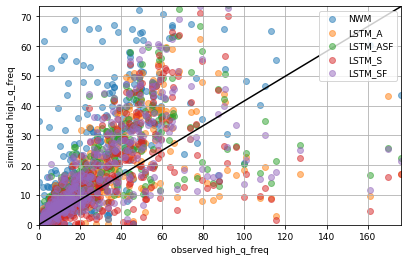

high_q_dur


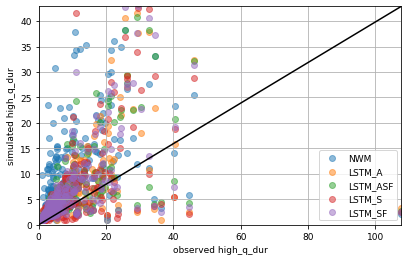

low_q_freq


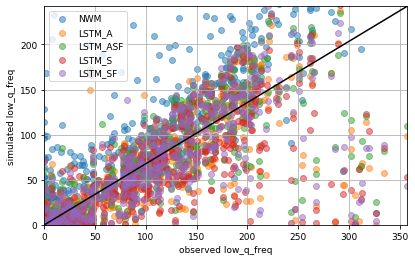

low_q_dur


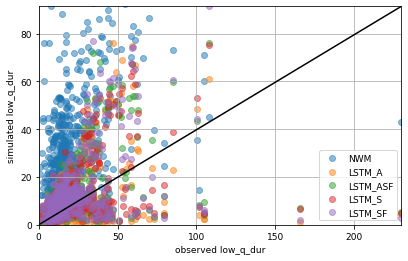

zero_q_freq


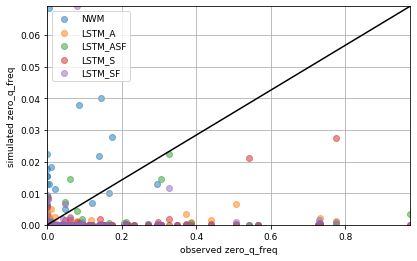

q95


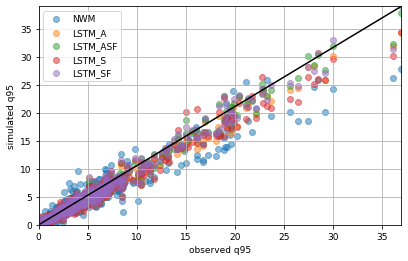

q5


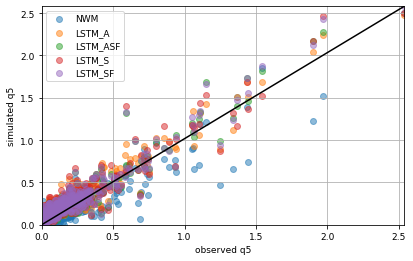

q_mean


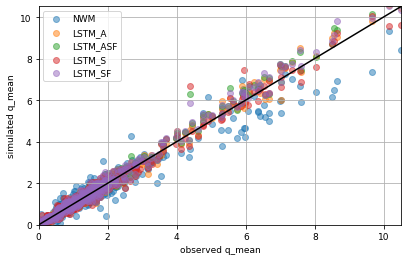

hfd_mean


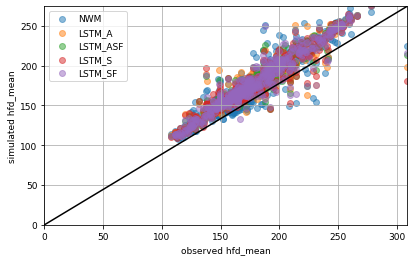

baseflow_index


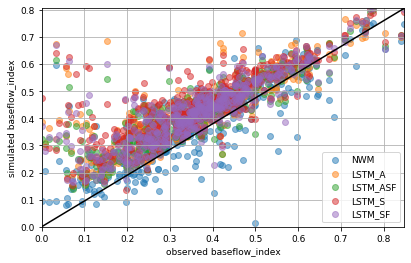

slope_fdc


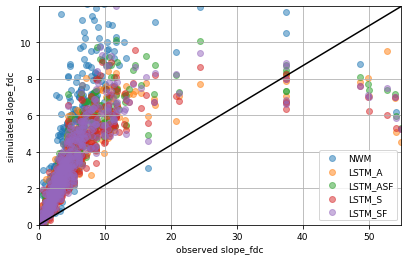

stream_elas


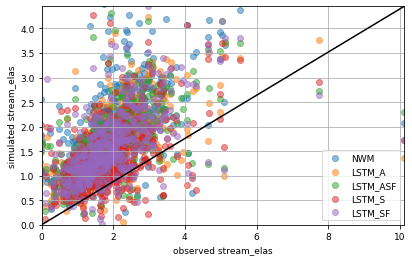

runoff_ratio


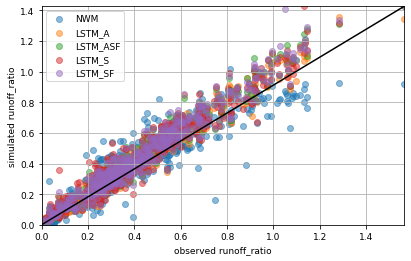

In [48]:
#RMSE Values
model_types = ['NWM','LSTM_A','LSTM_ASF', 'LSTM_S','LSTM_SF']

df_sigs={'rmse':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types),
         'r-squared':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types)}

df_sigs_signif = pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=['LSTM_A','LSTM_ASF', 'LSTM_S','LSTM_SF','n'])

for sig in sigs_dict['obs'].columns.values:
    print(sig)
    if sig=="zero_q_freq":
        df_temp = sigs_dict['obs'].loc[:,sig]
        count_zero_q_freq["obs"] = df_temp[df_temp > 0].count() 
        
    for imod in model_types:
        df_sigs['rmse'].loc[sig,imod] = np.log(np.sqrt(np.square(np.mean(sigs_dict['obs'].loc[:,sig] - 
                                         sigs_dict[imod].loc[:,sig]))))
        if sig=="zero_q_freq":
            df_temp = sigs_dict[imod].loc[:,sig]
            count_zero_q_freq[imod] = df_temp[df_temp > 0].count() 
            

    mpl.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    
    for imod in model_types:
        obs_1d = np.array(sigs_dict['obs'].loc[:,sig]).reshape(sigs_dict['obs'].loc[:,sig].shape[0],)
        sigs_1d = np.array(sigs_dict[imod].loc[:,sig]).reshape(sigs_dict[imod].loc[:,sig].shape[0],)
        df = pd.DataFrame({'obs':obs_1d, 'sig':sigs_1d})
        df = df.dropna()
        slope, intercept, r_value, p_value, std_err = st.linregress(df['obs'], df['sig'])

        df_sigs['r-squared'].loc[sig,imod] = r_value**2
        
        #Calculates the statistic significance between two dependent correlation coefficients
        if imod == 'LSTM_SF':
            df_nanfree = pd.DataFrame({'obs':sigs_dict['obs'].loc[:,sig],
                                       'NWM':sigs_dict['NWM'].loc[:,sig],
                                       'LSTM_A':sigs_dict['LSTM_A'].loc[:,sig],
                                       'LSTM_ASF':sigs_dict['LSTM_ASF'].loc[:,sig],
                                       'LSTM_SF':sigs_dict['LSTM_SF'].loc[:,sig],
                                       'LSTM_S':sigs_dict['LSTM_S'].loc[:,sig]})
            df_nanfree = df_nanfree.replace([np.inf, -np.inf], np.nan)
            df_nanfree = df_nanfree.dropna()

            xy = st.pearsonr(df_nanfree['NWM'], df_nanfree['obs'])[0]

            xz = st.pearsonr(df_nanfree['LSTM_SF'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['NWM'], df_nanfree['LSTM_SF'])[0]
            _, df_sigs_signif.loc[sig,'LSTM_SF'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])
            
            xz = st.pearsonr(df_nanfree['LSTM_S'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['NWM'], df_nanfree['LSTM_S'])[0]
            _, df_sigs_signif.loc[sig,'LSTM_S'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])

            xz = st.pearsonr(df_nanfree['LSTM_ASF'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['NWM'], df_nanfree['LSTM_ASF'])[0]
            _, df_sigs_signif.loc[sig,'LSTM_ASF'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])
            
            xz = st.pearsonr(df_nanfree['LSTM_A'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['NWM'], df_nanfree['LSTM_A'])[0]
            _, df_sigs_signif.loc[sig,'LSTM_A'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])
            
            df_sigs_signif.loc[sig,'n'] = df_nanfree.shape[0]
        
        ax.scatter(sigs_dict['obs'].loc[:,sig], sigs_dict[imod].loc[:,sig], alpha=.5, label=imod)
        plt.grid()
    
    plt.ylabel('simulated '+sig,fontname="Arial")
    plt.xlabel('observed '+sig,fontname="Arial")
    plt.plot([0,np.max(sigs_dict['obs'].loc[:,sig])],
             [0,np.max(sigs_dict[imod].loc[:,sig])], c='k')
    plt.xlim([0,np.max(sigs_dict['obs'].loc[:,sig])])
    plt.ylim([0,np.max(sigs_dict[imod].loc[:,sig])])
    plt.legend()
    plt.show()
    plt.close()

In [49]:
count_zero_q_freq

{'obs': 101,
 'NWM': 57,
 'LSTM_A': 35,
 'LSTM_Ac': 0,
 'LSTM_ASF': 29,
 'LSTM_SF': 25,
 'LSTM_S': 21,
 'LSTM_ASFc': 0}

In [50]:
df_sigs_signif

,LSTM_A,LSTM_ASF,LSTM_S,LSTM_SF,n
high_q_freq,0.29305,0.82749,0.03256,0.37300,531
high_q_dur,0.03848,0.03255,0.17915,0.03797,510
low_q_freq,0.07118,0.96668,0.00056,0.03258,531
low_q_dur,0.20994,0.70658,0.86772,0.55684,465
zero_q_freq,0.00014,0.00000,0.11711,0.00000,531
q95,0.00000,0.00000,0.00000,0.00000,531
q5,0.00000,0.00000,0.00040,0.00000,531
q_mean,0.00000,0.00000,0.00000,0.00000,531
hfd_mean,0.00004,0.00000,0.00139,0.00030,531
baseflow_index,0.72149,0.02402,0.03926,0.75016,531


In [51]:
sig='zero_q_freq'
df_nanfree = pd.DataFrame({'NWM':sigs_dict['NWM'].loc[:,sig],
                           'LSTM_ASF':sigs_dict['LSTM_ASF'].loc[:,sig],
                           'LSTM_A':sigs_dict['LSTM_A'].loc[:,sig],
                           'LSTM_SF':sigs_dict['LSTM_SF'].loc[:,sig],
                           'LSTM_S':sigs_dict['LSTM_S'].loc[:,sig]})
df_nanfree = df_nanfree.replace([np.inf, -np.inf], np.nan)
df_nanfree = df_nanfree.dropna()
count_above_zero = {'NWM':0, 'LSTM_A':0, 'LSTM_ASF':0, 'LSTM_SF':0, 'LSTM_S':0}
for i in df_nanfree.iterrows():
    for mod in ['NWM', 'LSTM_A', 'LSTM_ASF', 'LSTM_SF', 'LSTM_S']:
        if i[1][mod] > 0:
            count_above_zero[mod] += 1
count_above_zero

{'NWM': 57, 'LSTM_A': 35, 'LSTM_ASF': 29, 'LSTM_SF': 25, 'LSTM_S': 21}

In [52]:
df_sigs['r-squared'].sort_values('NWM').loc[:, ['NWM', 'LSTM_A','LSTM_ASF','LSTM_SF', 'LSTM_S']]

,NWM,LSTM_A,LSTM_ASF,LSTM_SF,LSTM_S
low_q_dur,0.15416,0.10477,0.14883,0.13700,0.15108
zero_q_freq,0.22281,0.07370,0.04524,0.00354,0.15504
high_q_dur,0.24113,0.38291,0.38572,0.38289,0.34635
stream_elas,0.28626,0.30852,0.32754,0.36572,0.20978
high_q_freq,0.50762,0.46121,0.49816,0.46842,0.41146
slope_fdc,0.51701,0.43846,0.43037,0.42312,0.41927
low_q_freq,0.60246,0.53012,0.60087,0.51598,0.45817
baseflow_index,0.71113,0.70029,0.77264,0.72056,0.64400
runoff_ratio,0.82127,0.95552,0.95251,0.95275,0.92955
hfd_mean,0.84806,0.90518,0.91584,0.89981,0.89479


In [53]:
for row in df_sigs['r-squared'].sort_values('NWM').loc[:, 
                        ['NWM', 'LSTM_A','LSTM_ASF','LSTM_SF', 'LSTM_S']].iterrows():
    LSTM_A_improvement = (row[1]['LSTM_A'] - row[1]['NWM'])/row[1]['NWM']
    LSTM_ASF_improvement = (row[1]['LSTM_ASF'] - row[1]['NWM'])/row[1]['NWM']
    states_improvement = (row[1]['LSTM_S'] - row[1]['NWM'])/row[1]['NWM']
    statesflux_improvement = (row[1]['LSTM_SF'] - row[1]['NWM'])/row[1]['NWM']
    
    print('{}: {:.0%}, {:.0%}, {:.0%}, {:.0%}'.format(row[0], LSTM_A_improvement, LSTM_ASF_improvement,
                                      states_improvement, statesflux_improvement))

low_q_dur: -32%, -3%, -2%, -11%
zero_q_freq: -67%, -80%, -30%, -98%
high_q_dur: 59%, 60%, 44%, 59%
stream_elas: 8%, 14%, -27%, 28%
high_q_freq: -9%, -2%, -19%, -8%
slope_fdc: -15%, -17%, -19%, -18%
low_q_freq: -12%, -0%, -24%, -14%
baseflow_index: -2%, 9%, -9%, 1%
runoff_ratio: 16%, 16%, 13%, 16%
hfd_mean: 7%, 8%, 6%, 6%
q5: 8%, 8%, 6%, 8%
q95: 8%, 8%, 6%, 7%
q_mean: 5%, 5%, 4%, 5%


In [54]:
df_sigs['r-squared'].sort_values('NWM').loc[:, ['NWM', 'LSTM_A','LSTM_ASF','LSTM_SF', 'LSTM_S']].mean()

NWM        0.58616
LSTM_A     0.59649
LSTM_ASF   0.61312
LSTM_SF    0.59677
LSTM_S     0.57485
dtype: float64

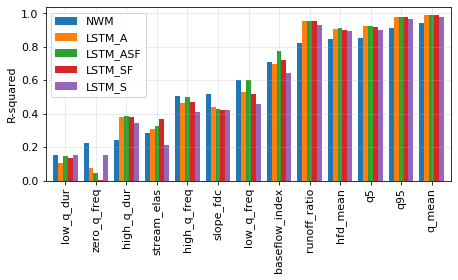

In [55]:
plot_model_names = ['NWM', 'LSTM_A','LSTM_ASF','LSTM_SF', 'LSTM_S']

fig_scale=1
mpl.rcParams.update({'font.size': 11})
#fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=False, figsize=(fig_scale*6.5, fig_scale*4.02))
fig, ax0 = plt.subplots(figsize=(fig_scale*6.5, fig_scale*4.02))

df_plot = df_sigs['r-squared'].sort_values('NWM').loc[:,['NWM', 'LSTM_A','LSTM_ASF','LSTM_SF', 'LSTM_S']]

df_plot.plot.bar(ax=ax0, width=.8)

ax0.set_ylabel('R-squared')
ax0.grid(alpha=0.3)
ax0.legend(plot_model_names)

plt.tight_layout()
plt.show()
plt.close()

# POST PROCESSOR PERFORMANCE REGRESSION

In [56]:
attributes['NWM'] = [np.nan]*attributes.shape[0]
attributes['LSTM_ASF-NWM'] = [np.nan]*attributes.shape[0]
imet=0
r=0
plot_change = np.full([nbasins,3],np.nan)
for i, b in enumerate(basin_list):
    attributes.loc[int(b), 'NWM'] = ensemble_metric_dictionary['NWM'][i,imet]
    attributes.loc[int(b), 'LSTM_ASF-NWM'] = ensemble_metric_dictionary['LSTM_ASF'][i,imet] - \
                       ensemble_metric_dictionary['NWM'][i,imet]
# Remove any rows with nan
df = attributes.dropna()

In [57]:
# 528 basins / 16 splits = 33 samples in each split.
n_splits = 16 

In [58]:
# Python program to sort  
# one list using 
# the other list 
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

In [59]:
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

In [60]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[]):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    grid = plt.GridSpec(1, 3, wspace=0.33333)
    plt.subplot(grid[0, 0:2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        plt.scatter(y_test,y_hat)
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))
    plt.xlabel("true target values")
    plt.ylabel("predicted values")

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept)
    plt.grid()
    
    plt.subplot(grid[0, 2])
    feature_importances.sort_values('total_importance', ascending=False).iloc[0:5].plot.bar(ax = plt.gca())
    plt.legend([])
    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [61]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [62]:
for i in range(df.shape[0]):
    df.basin_hydro_unit.iloc[i] = int(df.basin_hydro_unit.iloc[i])

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Overall rmse for the out-of-sample predictions: 0.86
Overall r^2 for the out-of-sample predictions: 0.30
RMSE Value stats for cross validation
mean = 0.65,  median = 0.46, stdev = 0.56, min = 0.16, max = 2.42
R-squared Value stats for cross validation
mean = 0.39,  median = 0.38, stdev = 0.31, min = 0.01, max = 0.95


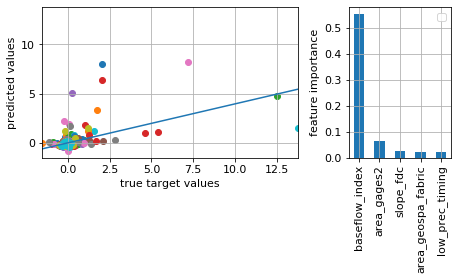

In [63]:
# Make a dictionary for all the X, y values
X = {'X_krig':np.array(df.loc[:,['gauge_lat','gauge_lon']])}
y = {}
z = {}
y_hat = {}
Cross = {}
regressor_attributes = list(attributes.columns.values[0:44])
regressor_attributes.append('basin_hydro_unit')
#regressor_attributes.append('nwm')
#regressor_attributes = ['nwm', 'baseflow_index', 'runoff_ratio', 'slope_fdc', 'stream_elas', 'basin_hydro_unit']
feature_list_short = ['nwm', 'B.I.', 'R.R.', 'F.D.C.', 'elast.', 'HUC']
target='LSTM_ASF-NWM'
ynormal = True
X[target], y[target] = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat[target], rmse, r2, feature_importance = cross_val_rf(X[target],y[target],regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)
#                min_weight_fraction_leaf=0, feature_list_short=feature_list_short)


### All NWM state and flux values

In [64]:
# load dynamic features data, which has all the NWM States and Fluxes
with open(data_dir+'dynamic_features_nwm_v2.p', 'rb') as f:
    dynamic_features_data = pkl.load(f)

In [65]:
nwm_columns = list(dynamic_features_data[sample_basin].columns[10:])

In [66]:
nwm_average_values = pd.DataFrame(index=basin_list, columns=nwm_columns)
for b, basin in enumerate(basin_list):
    nwm_average_values.loc[basin,:] = dynamic_features_data[basin].iloc[10:].mean()
nwm_average_values

,streamflow,q_lateral,velocity,qSfcLatRunoff,qBucket,qBtmVertRunoff,ACCET,FIRA,FSA,FSNO,...,SOIL_W1,SOIL_W2,SOIL_W3,SOIL_W4,TRAD,UGDRNOFF,mean_sfcheadsubrt,mean_zwattablrt,max_sfcheadsubrt,max_zwattablrt
01022500,11.80678,0.05726,0.67408,0.00901,0.04956,178.41287,0.16003,53.78358,133.90569,0.30298,...,0.27061,0.28866,0.30100,0.30613,280.38024,0.05956,0.00000,2.00000,0.00000,2.00000
01031500,14.91785,0.09322,0.11252,0.08603,0.01723,62.05605,0.14284,51.75442,128.54072,0.38806,...,0.28084,0.30631,0.32543,0.34309,278.06529,0.01613,0.00000,2.00000,0.00000,2.00000
01047000,20.97725,0.09989,0.76204,0.08411,0.02694,97.03694,0.14900,51.31855,135.75556,0.42473,...,0.23537,0.26322,0.28487,0.30819,277.45750,0.02696,0.00000,2.00000,0.00000,2.00000
01052500,9.32967,0.02324,1.15628,0.00081,0.03600,129.59121,0.14388,48.70902,128.11123,0.43817,...,0.28386,0.30584,0.31811,0.33307,276.81217,0.05022,0.00000,2.00000,0.00000,2.00000
01054200,5.51216,0.01970,0.96970,0.01941,0.01241,44.68099,0.17124,49.85445,142.05464,0.46513,...,0.21850,0.25635,0.28580,0.30695,276.62149,0.07554,0.00000,2.00000,0.00000,2.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11482500,25.29624,0.21110,0.58753,0.01624,0.19905,716.47005,0.14034,67.85576,179.18565,0.05828,...,0.31058,0.31471,0.32340,0.34778,283.74471,0.12721,0.00000,2.00000,0.00000,2.00000
11522500,57.19554,0.06526,1.44764,0.01183,0.05777,207.93827,0.11116,72.13259,174.51202,0.33703,...,0.24413,0.24986,0.25487,0.26544,280.66653,0.26009,0.00000,2.00000,0.00000,2.00000
11523200,11.01348,0.07853,1.11865,0.01893,0.06367,229.19817,0.06387,77.37446,164.46590,0.44909,...,0.17525,0.19248,0.21120,0.25821,278.51080,0.23864,0.00000,2.00000,0.00000,2.00000
11528700,42.45678,0.04810,1.02632,0.00260,0.05117,184.20374,0.16493,71.07061,177.73345,0.30486,...,0.25251,0.26180,0.26651,0.27415,280.68853,0.13078,0.00000,2.00000,0.00000,2.00000


In [67]:
nwm_average_values_soil_M = nwm_average_values.columns[14:18]
nwm_average_values_soil_W = nwm_average_values.columns[18:22]
nwm_average_values_soil_slim = nwm_average_values.copy(deep=True)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(nwm_average_values_soil_M, axis = 1)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(nwm_average_values_soil_W, axis = 1)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(['mean_sfcheadsubrt',
                                'mean_zwattablrt','max_sfcheadsubrt','max_zwattablrt'], axis = 1)
nwm_average_values_soil_slim['SM_W'] = np.mean(nwm_average_values.loc[:,nwm_average_values_soil_W], axis=1)
nwm_average_values_soil_slim['SM_M'] = np.mean(nwm_average_values.loc[:,nwm_average_values_soil_M], axis=1)

nwm_average_values_soil_slim['zwattablrt'] = np.mean(nwm_average_values.loc[:,
                                                    ('mean_zwattablrt','max_zwattablrt')], axis=1)
nwm_average_values_soil_slim['sfcheadsubrt'] = np.mean(nwm_average_values.loc[:,
                                                    ('mean_sfcheadsubrt','max_sfcheadsubrt')], axis=1)
nwm_average_values_soil_slim
nwm_columns_soil_slim = nwm_average_values_soil_slim.columns.values

In [68]:
optimal = [1, 0, 0]
improvements = {}
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        for imet, metric in enumerate(use_metrics):
            control = met_mat[fc][:,imt,imet]       #metric_values.loc[:,(hyd, metric, 'test')]
            test = met_mat[fc][:,2,imet]
            if optimal[imt] == 1:
                improvements[(fc,mod,metric)] = test-control
            elif optimal[imt] == 0:
                improvements[(fc,mod,metric)] = (np.abs(test)-np.abs(control))

In [69]:
corr = {}
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        corr[(fc,mod)] = pd.DataFrame(index=nwm_columns_soil_slim, columns=use_metrics)
        for imet, metric in enumerate(use_metrics):
            for i, inpt in enumerate(nwm_columns_soil_slim):
                x = nwm_average_values_soil_slim[inpt].values.astype(float)
                y = improvements[(fc,mod,metric)]
                corr[(fc,mod)].loc[inpt,metric] = np.corrcoef(x, y)[0,1]          

In [70]:
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        corr[(fc,mod)].rename(columns={use_metrics[0]:short_metric_names[0], use_metrics[1]:short_metric_names[1],
                    use_metrics[2]:short_metric_names[2]})
        corr[(fc,mod)] = corr[(fc,mod)].rename(index={'qSfcLatRunoff':'qLateral', 'qBtmVertRunoff':'qBottom'})

In [71]:
corr

{('all',
  'NWM'):                   NSE Beta-NSE Peak-Timing
 streamflow   -0.07965 -0.19560    -0.08959
 q_lateral    -0.06500 -0.07655    -0.00054
 velocity      0.01718 -0.23130    -0.18640
 qLateral     -0.08776 -0.03829     0.03965
 qBucket      -0.02908 -0.10219    -0.04641
 qBottom      -0.02913 -0.10212    -0.04630
 ACCET        -0.06725  0.20134     0.16948
 FIRA          0.13515  0.06703     0.03051
 FSA          -0.04031  0.09961     0.17096
 FSNO          0.13416 -0.16061    -0.24621
 HFX          -0.09910 -0.07345     0.08481
 LH           -0.06538  0.20336     0.17022
 SNEQV         0.01601 -0.23845    -0.26373
 SNOWH         0.02706 -0.25603    -0.29321
 TRAD         -0.13051  0.19428     0.26245
 UGDRNOFF      0.03110 -0.37268    -0.28979
 SM_W         -0.10192 -0.00386     0.08541
 SM_M         -0.04126 -0.01540     0.03693
 zwattablrt   -0.03745 -0.14868    -0.11823
 sfcheadsubrt -0.01104  0.01333     0.00904,
 ('all',
  'LSTM_A'):                   NSE Beta-NSE Peak

Text(0, 0.5, 'Correlation')

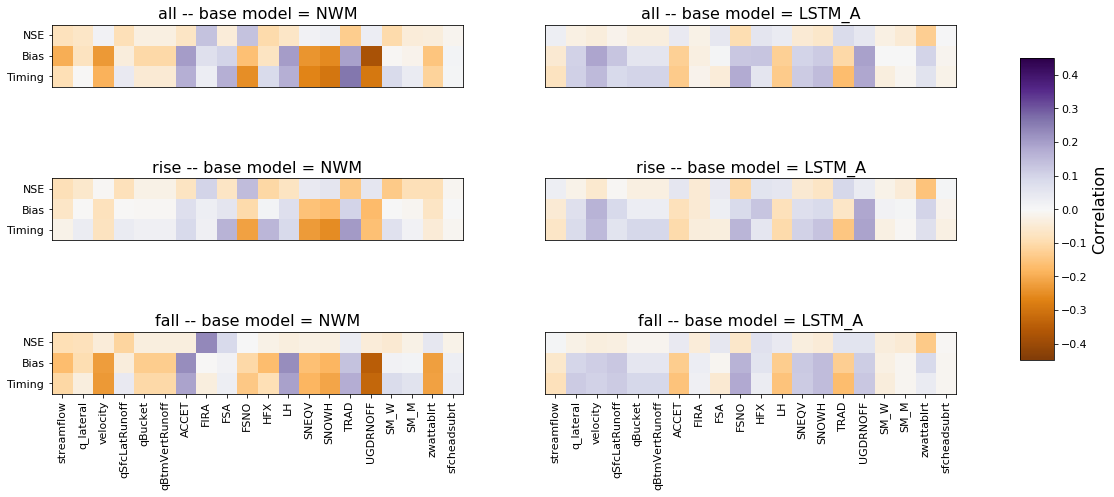

In [73]:
fig, ax = plt.subplots(3,2,figsize=(16,8))
for ifc,fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        im = ax[ifc,imt].imshow(corr[(fc,mod)].transpose().astype(float),
                       cmap='PuOr',
                      vmax=0.45, vmin=-0.45)
        ax[ifc,imt].set_xticks([])
        ax[ifc,imt].set_yticks([])
        ax[ifc,imt].set_title(f"{fc.replace('_',' ')} -- base model = {base_models[imt]}", fontsize=16)
        
ax[2,0].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[2,1].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[2,0].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')
ax[2,1].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')

ax[0,0].set_yticks(range(len(use_metrics)))
ax[1,0].set_yticks(range(len(use_metrics)))
ax[2,0].set_yticks(range(len(use_metrics)))
ax[0,0].set_yticklabels(short_metric_names)
ax[1,0].set_yticklabels(short_metric_names)
ax[2,0].set_yticklabels(short_metric_names)

fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.965, 0.24, 0.03, 0.525])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Correlation', fontsize=16)


Text(0, 0.5, 'Correlation')

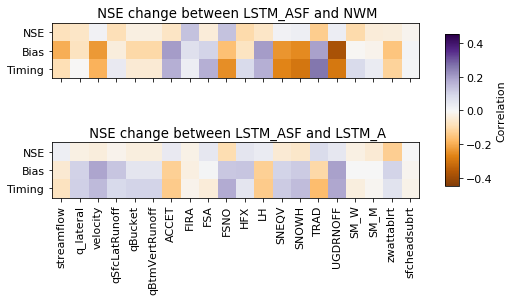

In [75]:
mpl.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(2,1,figsize=(6.5,4.02))
for imt, mod in enumerate(base_models):
    im = ax[imt].imshow(corr[('all',mod)].transpose().astype(float),
                   cmap='PuOr',
                  vmax=0.45, vmin=-0.45)
    ax[imt].set_xticks([])
    ax[imt].set_yticks([])
    ax[imt].set_title(' NSE change between LSTM_ASF and ' + base_models[imt])
        
ax[0].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[1].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[0].set_xticklabels([])
ax[1].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')

ax[0].set_yticks(range(len(use_metrics)))
ax[1].set_yticks(range(len(use_metrics)))
ax[0].set_yticklabels(short_metric_names)
ax[1].set_yticklabels(short_metric_names)

fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.965, 0.24, 0.03, 0.525])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Correlation')

In [76]:
for imt, mod in enumerate(base_models):
    print(np.abs(np.mean(corr[('all',mod)].transpose().astype(float), axis=0)).sort_values())

sfcheadsubrt   0.00378
SM_M           0.00658
SM_W           0.00679
qLateral       0.02880
HFX            0.02925
q_lateral      0.04736
qBottom        0.05919
qBucket        0.05923
FSA            0.07675
FIRA           0.07756
FSNO           0.09088
ACCET          0.10119
zwattablrt     0.10145
LH             0.10273
TRAD           0.10874
streamflow     0.12161
velocity       0.13350
SNEQV          0.16206
SNOWH          0.17406
UGDRNOFF       0.21045
dtype: float64
FSA            0.00487
sfcheadsubrt   0.00952
zwattablrt     0.01203
SM_M           0.01799
SM_W           0.01894
FIRA           0.02318
streamflow     0.03203
qBottom        0.04071
qBucket        0.04073
SNEQV          0.05689
q_lateral      0.06068
TRAD           0.06201
SNOWH          0.06749
qLateral       0.06768
FSNO           0.07008
ACCET          0.07366
LH             0.07382
HFX            0.07941
velocity       0.09994
UGDRNOFF       0.14207
dtype: float64


# Split by if calibrated basin

                  mean  median      max       min
NWM            0.48785 0.62856  0.94170 -10.81832
LSTM_A         0.68204 0.73876  0.92232  -0.60125
LSTM_A(C)      0.67384 0.73463  0.92333  -0.97832
LSTM_ASF       0.66493 0.74578  0.92329  -3.07345
LSTM_ASF(C)    0.66821 0.74642  0.92679  -2.34372
LSTM_A - NWM   0.18599 0.08756 10.57499  -0.44817
LSTM_ASF - NWM 0.18036 0.09934  8.47461  -0.71028
                   mean  median     max       min
NWM             0.13869 0.45873 0.76924  -8.74918
LSTM_A          0.72931 0.75161 0.89094   0.42503
LSTM_A(C)       0.48640 0.66731 0.84557  -2.99519
LSTM_ASF        0.70889 0.72251 0.89758   0.42010
LSTM_ASF(C)     0.03191 0.60519 0.84614 -19.58815
LSTM_A - NWM    0.34772 0.12511 5.75399  -0.58277
LSTM_ASF - NWM -0.10678 0.12983 2.51282 -10.83897
significance tests
cal_bas_nwm vs uncal_bas_nwm 6.280316715470989e-06
cal_bas_v0 vs uncal_bas_v0 0.2486164486082456
cal_bas_v0c vs uncal_bas_v0c 4.241845591253745e-06
cal_bas_v2 vs uncal_bas_v2 0.1705

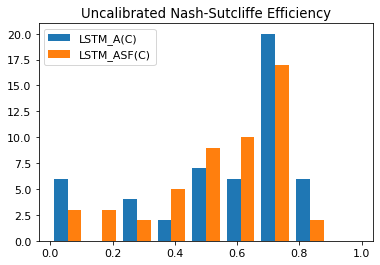

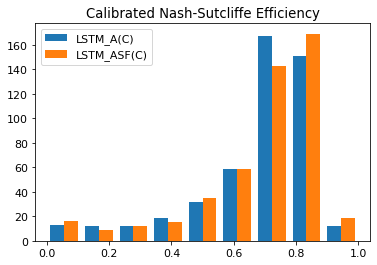

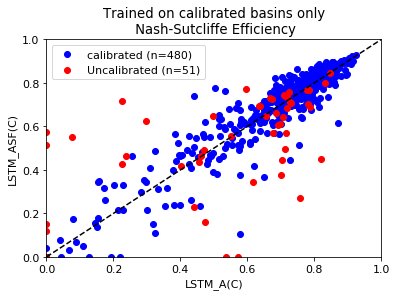

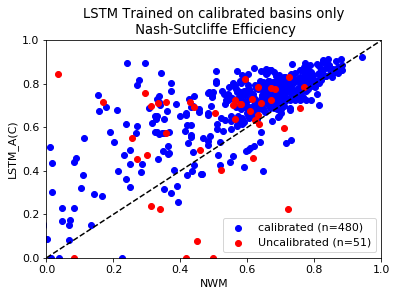

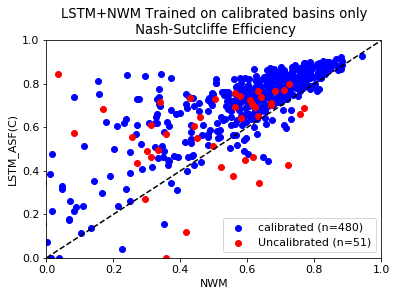

                   mean   median     max      min
NWM             0.01692 -0.00559 2.58056 -0.64917
LSTM_A          0.02482  0.02165 0.59617 -0.20620
LSTM_A(C)       0.02794  0.02007 0.64939 -0.19588
LSTM_ASF        0.03497  0.02358 0.97943 -0.21681
LSTM_ASF(C)     0.01343  0.00136 0.91267 -0.22227
LSTM_A - NWM    0.01101  0.01766 0.80372 -2.49717
LSTM_ASF - NWM -0.00350  0.00690 0.55297 -1.66790
                  mean   median     max      min
NWM            0.01368 -0.04919 2.04709 -0.56028
LSTM_A         0.02646  0.01237 0.24206 -0.11015
LSTM_A(C)      0.10004  0.04176 1.11397 -0.20545
LSTM_ASF       0.01789 -0.00452 0.23080 -0.10958
LSTM_ASF(C)    0.07407 -0.04021 3.43371 -0.37001
LSTM_A - NWM   0.08636  0.06836 1.14153 -0.93312
LSTM_ASF - NWM 0.06039  0.00033 1.62624 -0.36121
significance tests
cal_bas_nwm vs uncal_bas_nwm 0.03356018414890447
cal_bas_v0 vs uncal_bas_v0 0.37462470267138814
cal_bas_v0c vs uncal_bas_v0c 0.03917212751820825
cal_bas_v2 vs uncal_bas_v2 0.097007050178766

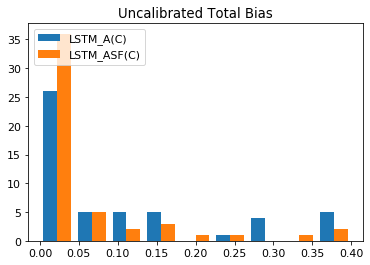

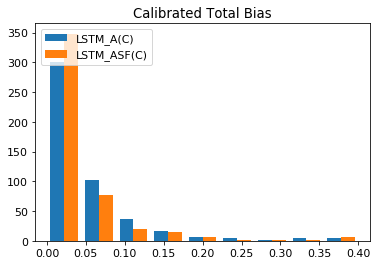

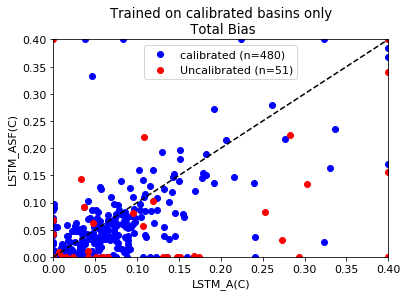

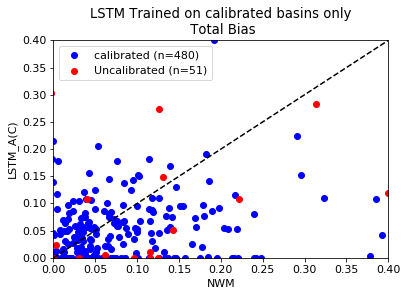

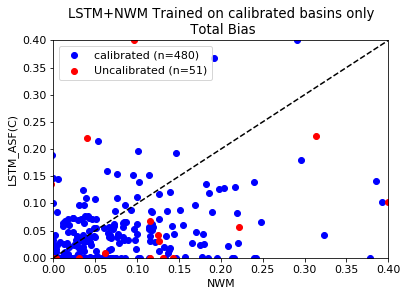

                   mean   median     max      min
NWM             1.05113  0.88000 3.00000  0.12000
LSTM_A          0.52768  0.44000 1.68000  0.04167
LSTM_A(C)       0.52448  0.45833 1.76000  0.03846
LSTM_ASF        0.54015  0.42308 1.76923  0.04167
LSTM_ASF(C)     0.54196  0.42308 1.78261  0.04000
LSTM_A - NWM   -0.52665 -0.42308 0.44444 -2.00000
LSTM_ASF - NWM -0.50917 -0.41667 0.39130 -2.14286
                   mean   median     max      min
NWM             1.01875  0.73913 2.80769  0.20000
LSTM_A          0.51923  0.40000 1.45455  0.07407
LSTM_A(C)       0.59252  0.52000 1.50000  0.11111
LSTM_ASF        0.51766  0.39130 1.59091  0.04167
LSTM_ASF(C)     0.60144  0.44000 1.86364  0.08000
LSTM_A - NWM   -0.42623 -0.40000 0.35714 -1.69231
LSTM_ASF - NWM -0.41731 -0.37500 0.28571 -1.42308
significance tests
cal_bas_nwm vs uncal_bas_nwm 0.26194755714343976
cal_bas_v0 vs uncal_bas_v0 0.2569262066843146
cal_bas_v0c vs uncal_bas_v0c 0.09306709442391253
cal_bas_v2 vs uncal_bas_v2 0.12662910

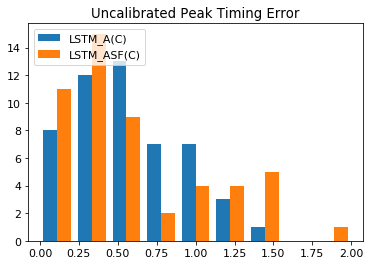

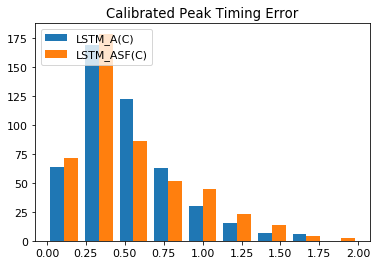

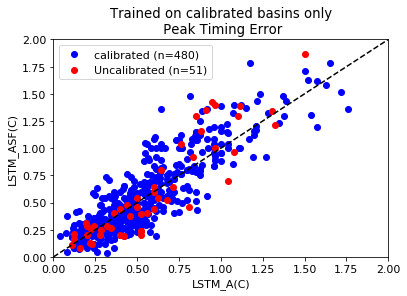

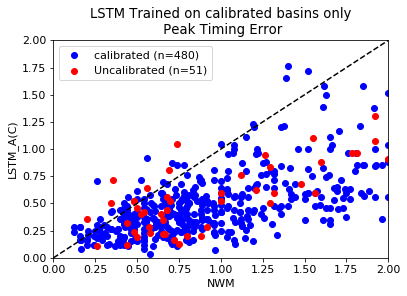

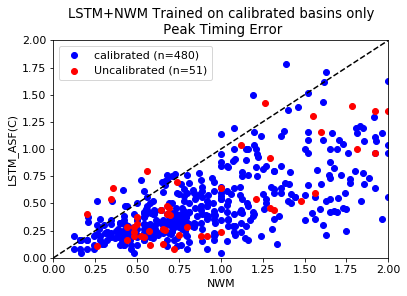

In [78]:
for imet, nmet in enumerate([0,6,11]):
    attributes2 = attributes.copy(deep=True)
    
    list_mod = ['NWM','LSTM_A','LSTM_Ac','LSTM_ASF','LSTM_ASFc','diff0','diff2','diff0c','diff2c','diff0c2c']
    for imod in list_mod:
        attributes2[imod] = [np.nan]*attributes2.shape[0]

    r=0
    for i, b in enumerate(basin_list):
        for imod in ['LSTM_A','LSTM_Ac','LSTM_ASF','LSTM_ASFc','NWM']:
            attributes2.loc[int(b), imod] = ensemble_metric_dictionary[imod][i,nmet]
        attributes2.loc[int(b), 'diff0'] = \
                           ensemble_metric_dictionary['LSTM_A'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff2'] = \
                           ensemble_metric_dictionary['LSTM_ASF'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff0c'] = \
                           ensemble_metric_dictionary['LSTM_Ac'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff2c'] = \
                           ensemble_metric_dictionary['LSTM_ASFc'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff0c2c'] = \
                           ensemble_metric_dictionary['LSTM_Ac'][i,nmet] - \
                           ensemble_metric_dictionary['LSTM_ASFc'][i,nmet]

    # Remove any rows with nan
    df = attributes2.dropna()

    mod_namez = ['NWM', 'LSTM_A', 'LSTM_A(C)', 'LSTM_ASF', 'LSTM_ASF(C)', 'LSTM_A - NWM', 'LSTM_ASF - NWM']
    cal_df = pd.DataFrame(index=mod_namez, columns=['mean', 'median', 'max', 'min'])
    uncal_df = pd.DataFrame(index=mod_namez, columns=['mean', 'median', 'max', 'min'])    
    for model_type, model_namex in zip(['NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_ASFc', 'diff0c', 'diff2c'], mod_namez):
        uncal_df.loc[model_namex, 'mean'] = df.groupby('calibrated')[model_type].mean()[0]
        uncal_df.loc[model_namex, 'median'] = df.groupby('calibrated')[model_type].median()[0]
        uncal_df.loc[model_namex, 'max'] = df.groupby('calibrated')[model_type].max()[0]
        uncal_df.loc[model_namex, 'min'] = df.groupby('calibrated')[model_type].min()[0]
        cal_df.loc[model_namex, 'mean'] = df.groupby('calibrated')[model_type].mean()[1]
        cal_df.loc[model_namex, 'median'] = df.groupby('calibrated')[model_type].median()[1]
        cal_df.loc[model_namex, 'max'] = df.groupby('calibrated')[model_type].max()[1]
        cal_df.loc[model_namex, 'min'] = df.groupby('calibrated')[model_type].min()[1]
    print(cal_df)
    print(uncal_df)
    
    cal_dict = {imod:[] for imod in list_mod}
    uncal_dict = {imod:[] for imod in list_mod}
    
    for ib, b in enumerate(basin_list):
        if int(b) in list(df.index.values):
            if df.loc[int(b),'calibrated']:
                for imod in list_mod:
                    cal_dict[imod].append(df.loc[int(b),imod])
            else:
                for imod in list_mod:
                    uncal_dict[imod].append(df.loc[int(b),imod])

    # Check for significance between the two samples.
    print('significance tests')
    print('cal_bas_nwm vs uncal_bas_nwm', st.mannwhitneyu(cal_dict['NWM'], uncal_dict['NWM'])[1])
    print('cal_bas_v0 vs uncal_bas_v0', st.mannwhitneyu(cal_dict['LSTM_A'], uncal_dict['LSTM_A'])[1])
    print('cal_bas_v0c vs uncal_bas_v0c', st.mannwhitneyu(cal_dict['LSTM_Ac'], uncal_dict['LSTM_Ac'])[1])
    print('cal_bas_v2 vs uncal_bas_v2', st.mannwhitneyu(cal_dict['LSTM_ASF'], uncal_dict['LSTM_ASF'])[1])
    print('cal_bas_v2c vs uncal_bas_v2c', st.mannwhitneyu(cal_dict['LSTM_ASFc'], uncal_dict['LSTM_ASFc'])[1])
    print('diff0_cal vs diff0_uncal', st.mannwhitneyu(cal_dict['diff0'], uncal_dict['diff0'])[1])
    print('diff2_cal vs diff2_uncal', st.mannwhitneyu(cal_dict['diff2'], uncal_dict['diff2'])[1])
    print('diff0c_cal vs diff0c_uncal', st.mannwhitneyu(cal_dict['diff0c'], uncal_dict['diff0c'])[1])
    print('diff2c_cal vs diff2c_uncal', st.mannwhitneyu(cal_dict['diff2c'], uncal_dict['diff2c'])[1])
    print('diff0c2c_cal vs diff0c2c_uncal', st.mannwhitneyu(cal_dict['diff0c2c'], uncal_dict['diff0c2c'])[1])
    print('cal_bas_v0c vs cal_bas_v2c', st.wilcoxon(cal_dict['LSTM_Ac'], cal_dict['LSTM_ASFc'])[1])
    print('uncal_bas_v0c vs uncal_bas_v2c', st.wilcoxon(uncal_dict['LSTM_Ac'], uncal_dict['LSTM_ASFc'])[1])
    
    for imod in ['LSTM_Ac', 'LSTM_ASFc']:
        for idict in [cal_dict, uncal_dict]:
            for i, j in enumerate(idict[imod]):
                if j < met_lims[nmet][0]:
                    idict[imod][i] = met_lims[nmet][0]
                if j > met_lims[nmet][1]:
                    idict[imod][i] = met_lims[nmet][1]
    
    # Uncalibrated
    bins = np.linspace(met_lims[nmet][0], met_lims[nmet][1], 10)
    plt.hist([uncal_dict['LSTM_Ac'], uncal_dict['LSTM_ASFc']], bins, label=['LSTM_A(C)', 'LSTM_ASF(C)'])
    plt.title('Uncalibrated '+use_metric_names[imet])
    plt.legend(loc='upper left')
    plt.show()
    plt.close()
    # Calibrated
    bins = np.linspace(met_lims[nmet][0], met_lims[nmet][1], 10)
    plt.hist([cal_dict['LSTM_Ac'], cal_dict['LSTM_ASFc']], bins, label=['LSTM_A(C)', 'LSTM_ASF(C)'])
    plt.title('Calibrated '+use_metric_names[imet])
    plt.legend(loc='upper left')
    plt.show()
    plt.close()

    # Scatter plot comparing the LSTM and LSTM+NWM trained on calibrated only, tested on all
    plt_limz = met_lims[nmet]
    plt.scatter(cal_dict['LSTM_Ac'], cal_dict['LSTM_ASFc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['LSTM_Ac'], uncal_dict['LSTM_ASFc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title('Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_ASF(C)')
    plt.xlabel('LSTM_A(C)')
    plt.legend()
    plt.show()
    plt.close()

    plt_limz = met_lims[nmet]
    plt.scatter(cal_dict['NWM'], cal_dict['LSTM_Ac'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['NWM'], uncal_dict['LSTM_Ac'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title('LSTM Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_A(C)')
    plt.xlabel('NWM')
    plt.legend()
    plt.show()
    plt.close()

    
    plt_limz = met_lims[nmet]
    plt.scatter(cal_dict['NWM'], cal_dict['LSTM_ASFc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['NWM'], uncal_dict['LSTM_ASFc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title('LSTM+NWM Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_ASF(C)')
    plt.xlabel('NWM')
    plt.legend()
    plt.show()
    plt.close()


In [79]:
ensemble_metric_dictionary_cal = ensemble_metric_dictionary.copy()
ensemble_metric_dictionary_uncal = ensemble_metric_dictionary.copy()
cal_del_id = []
uncal_del_id = []
for ib, b in enumerate(basin_list):
    if b in cb:
        cal_del_id.append(ib)
    else:
        uncal_del_id.append(ib)
for ik, k in enumerate(ensemble_metric_dictionary.keys()):
    ensemble_metric_dictionary_cal[k] = np.delete(ensemble_metric_dictionary_cal[k], (uncal_del_id), axis=0)
    ensemble_metric_dictionary_uncal[k] = np.delete(ensemble_metric_dictionary_uncal[k], (cal_del_id), axis=0)

In [80]:
plot_these_curves = [0,1,2,3,6]

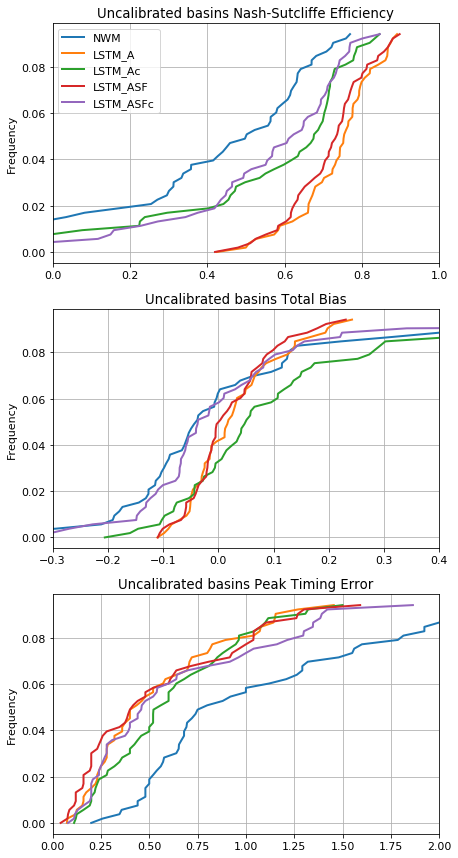

In [82]:
##### UNCALIBRATED BASINS
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [-.3,.4],[-50,50], [],[],[],[0,2]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,1, figsize=(6.5,3*4.02))

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary_uncal[SMN][:,nmet]) for SMN in nwm_lstm_version_list]
#    for imod,X in enumerate(x):
    for imod in plot_these_curves:
        plotdata = x[imod]
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        label_name = nwm_lstm_version_list[imod]
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], label=label_name, lw=2)
        axes[imet].grid()
        axes[imet].set_xlim(list(met_lims[nmet]))
        axes[imet].set_title('Uncalibrated basins ' + metric_names[imet])
        axes[imet].set_ylabel('Frequency')
        
axes[0].legend()
fig.tight_layout() 

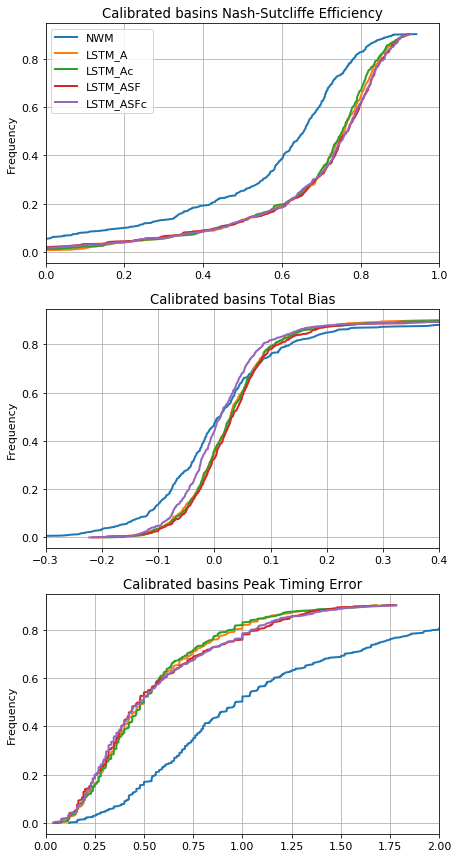

In [85]:
##### CALIBRATED BASINS
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [-.3,.4],[-50,50], [],[],[],[0,2]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,1, figsize=(6.5,3*4.02))

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary_cal[SMN][:,nmet]) for SMN in nwm_lstm_version_list]
#    for imod,X in enumerate(x):
    for imod in plot_these_curves:
        plotdata = x[imod]
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        label_name = nwm_lstm_version_list[imod]
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], label=label_name, lw=2)
        axes[imet].grid()
        axes[imet].set_xlim(list(met_lims[nmet]))
        axes[imet].set_title('Calibrated basins ' + metric_names[imet])
        axes[imet].set_ylabel('Frequency')
        
axes[0].legend()
fig.tight_layout() 

# Regional analysis

In [87]:
unique_hydro_unit = attributes.basin_hydro_unit.unique()
nregions = len(unique_hydro_unit)

In [88]:
unique_hydro_unit

array(['01', '02', '03', '05', '06', '04', '09', '07', '10', '11', '08',
       '12', '13', '14', '15', '16', '18', '17'], dtype=object)

In [111]:
def calc_wilcoxon_huc(huc, M_base, M_test):
    _, p = st.wilcoxon(huc_stat[M_base][huc], huc_stat[M_test][huc])
    return p

In [112]:
# Need an array with huc,metric,basin,model
mod_types = ['NWM', 'LSTM_ASF', 'LSTM_A']

huc_stat_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=mod_types) for m in metric_names}

for imet, nmet in enumerate([0,6,11]):
    
    huc_stat = {model:{huc:[] for huc in unique_hydro_unit} for model in mod_types}

    for ihuc, huc in enumerate(unique_hydro_unit):
        for ib, b in enumerate(basin_list):
            if attributes.loc[int(b), 'basin_hydro_unit'] == huc:
                for imod, mod_name in enumerate(mod_types):
                    huc_stat[mod_name][huc].append(ensemble_metric_dictionary[mod_name][ib,nmet])
        for imod, mod_name in enumerate(mod_types):
            huc_stat_dict[metric_names[imet]].loc[huc,mod_name] = np.mean(huc_stat[mod_name][huc])


huc_sig_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=['NWM', 'LSTM_A', 'n']) for m in metric_names}
for imet, nmet in enumerate([0,6,11]):
    for ihuc, huc in enumerate(unique_hydro_unit):
        p = calc_wilcoxon_huc(huc, 'NWM', 'LSTM_ASF')
        huc_sig_dict[metric_names[imet]].loc[huc,'NWM'] = p
        p = calc_wilcoxon_huc(huc, 'LSTM_A', 'LSTM_ASF')
        huc_sig_dict[metric_names[imet]].loc[huc,'LSTM_A'] = p
        huc_sig_dict[metric_names[imet]].loc[huc,'n'] = len(huc_stat[mod_name][huc])

for m in metric_names:
    huc_sig_dict[m] = huc_sig_dict[m].sort_index()
    huc_stat_dict[m] = huc_stat_dict[m].sort_index()

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [113]:
huc_sig_dict

{'Nash-Sutcliffe Efficiency':        NWM  LSTM_A   n
 01 0.00007 0.93058  22
 02 0.00000 0.00552  69
 03 0.00000 0.14278  79
 04 0.00001 0.91519  30
 05 0.00000 0.06667  35
 06 0.00065 0.45070  16
 07 0.00000 0.18076  29
 08 0.07474 0.46307   7
 09 0.17971 0.65472   2
 10 0.00000 0.07316  49
 11 0.00004 0.82276  22
 12 0.00000 0.79708  32
 13 0.01796 0.02728   7
 14 0.00065 0.19812  15
 15 0.00123 0.02194  14
 16 0.04311 0.14413   5
 17 0.00000 0.46292  72
 18 0.00001 0.11017  26,
 'Total Bias':        NWM  LSTM_A   n
 01 0.00007 0.93058  22
 02 0.00000 0.00552  69
 03 0.00000 0.14278  79
 04 0.00001 0.91519  30
 05 0.00000 0.06667  35
 06 0.00065 0.45070  16
 07 0.00000 0.18076  29
 08 0.07474 0.46307   7
 09 0.17971 0.65472   2
 10 0.00000 0.07316  49
 11 0.00004 0.82276  22
 12 0.00000 0.79708  32
 13 0.01796 0.02728   7
 14 0.00065 0.19812  15
 15 0.00123 0.02194  14
 16 0.04311 0.14413   5
 17 0.00000 0.46292  72
 18 0.00001 0.11017  26,
 'Peak Timing Error':        NWM  LSTM_A   

In [108]:
huc_stat_dict

{'Nash-Sutcliffe Efficiency':         NWM LSTM_ASF  LSTM_A
 01  0.61806  0.78456 0.78126
 02  0.49219  0.73724 0.70822
 03  0.55940  0.70858 0.70801
 05  0.63217  0.74391 0.73444
 06  0.69502  0.79907 0.79346
 04  0.41345  0.68961 0.71238
 09  0.29106  0.39866 0.28411
 07  0.46030  0.70512 0.70100
 10 -0.06046  0.45761 0.57466
 11  0.31163  0.56257 0.62773
 08  0.61203  0.67348 0.69424
 12  0.27728  0.32722 0.35123
 13  0.23574  0.63243 0.62093
 14  0.50408  0.74330 0.80038
 15 -0.01727  0.33616 0.44683
 16  0.22194  0.70611 0.72321
 18  0.58718  0.73869 0.75109
 17  0.67068  0.80689 0.81491,
 'Total Bias':         NWM LSTM_ASF   LSTM_A
 01 -0.04713  0.06614  0.07764
 02  0.02516  0.03248  0.03342
 03  0.01517 -0.01625 -0.01130
 05 -0.04016  0.02904  0.03404
 06 -0.01340  0.00013 -0.00086
 04  0.00473  0.04816  0.06122
 09 -0.16034  0.08552  0.07326
 07  0.11421  0.09494  0.08222
 10  0.14076  0.08423  0.05508
 11  0.04862  0.04392  0.00646
 08  0.00825 -0.02980 -0.03813
 12 -0.00649 -

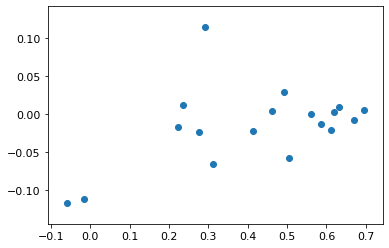

In [107]:
diffss = (huc_stat_dict['Nash-Sutcliffe Efficiency']['LSTM_ASF'].values - 
          huc_stat_dict['Nash-Sutcliffe Efficiency']['LSTM_A'].values)
plt.scatter(huc_stat_dict['Nash-Sutcliffe Efficiency']['NWM'].values, diffss)